In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 1
EPOCH = 100

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "sigmoid"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 3e-4
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)

    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    perceptual_l = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        _gen = nn.BCELoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size(), dtype=torch.float, device=device))
        _dis = nn.BCELoss()(y_cls.float(), torch.ones(y_cls.size(), dtype=torch.float, device=device)) + \
                                nn.BCELoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size(), dtype=torch.float, device=device))

        dis_optimizer.zero_grad()
        gen_optimizer.zero_grad()
        
        # main loss
        _mae = MAELoss()(y_pr.float(), y.float())
        _ssim =SSIMLoss()(y_pr, y, data_range=1.0, size_average=True) # return (N,)
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-257, -256)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())

        _loss = _gen + air_loss + _mae + _ssim + _dis
        _loss.backward()    
        gen_optimizer.step()
        dis_optimizer.step()

        dis_l += _gen.item()
        gen_l += _dis.item()
        air_l += air_loss.item()
        ssim_l += _ssim.item()
        mae_l += _mae.item()
        
    return  mae_l/(index+1), ssim_l/(index+1), air_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [13]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)

    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-257, -256)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        upper = ((256) - (_min))/(_max-(_min))
        lower = ((255) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        acc = Accuracy()(y_cls, torch.ones(y_cls.size(), device=y_cls.device))
        acc_ += [acc.item()]
        acc = Accuracy()(y_pr_cls, torch.zeros(y_pr_cls.size(), device=y_pr_cls.device))
        acc_ += [acc.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(acc_)/len(acc_)

In [14]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        _min = -500
        _max = 500
        air_window = (-257, -256)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        
        upper = ((256) - (_min))/(_max-(_min))
        lower = ((255) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)

        for b in range(x.shape[0]):
            
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            
            __cbct = (x.squeeze().cpu().numpy()[b, :, :] * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                ct_masked = __ct_masked,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "ct_masked.jpg"), __ct_masked)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                
            iid += 1

# Discriminator

In [15]:
from codes.activation import Activation
import torchvision.models as models

In [16]:
class Model(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Model, self).__init__()
        
        encoder = models.resnet152()
        encoder.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        encoder.fc = nn.Linear(in_features=2048, out_features=n_classes)
        self.encoder = encoder
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return self.activation(x)

# Read Data

In [17]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [18]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [19]:
trainset = Dataset(path=train_case_path, geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [20]:
len(trainset), len(testset)

(1344, 191)

In [21]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f2030782ac0>,)

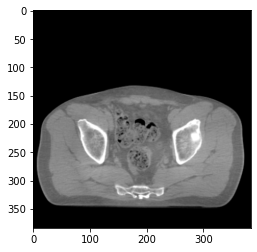

In [22]:
plt.imshow(x.squeeze(), 'gray'),

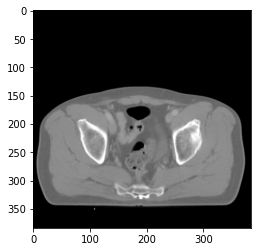

In [23]:
plt.imshow(y.squeeze(), 'gray')

In [24]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [25]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet152"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [26]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [27]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)

In [28]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [29]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

In [30]:
wandb.watch(model)
wandb.watch(discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_mae, loss_ssim, loss_air, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        
        wandb.log({
            "loss ssim": loss_ssim,
            "loss mae": loss_mae,
            "loss mask": loss_air,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_bone_test +  score_air_test >  max_score:
            max_score = score_bone_test +  score_air_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

168it [02:04,  1.35it/s]
168it [00:37,  4.49it/s]
24it [00:05,  4.25it/s]
168it [02:04,  1.35it/s]
168it [00:37,  4.46it/s]
24it [00:05,  4.22it/s]
168it [02:05,  1.34it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.22it/s]
168it [02:05,  1.34it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.21it/s]
168it [02:05,  1.34it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.20it/s]
168it [02:05,  1.34it/s]
168it [00:37,  4.44it/s]
24it [00:05,  4.22it/s]
168it [02:05,  1.34it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.22it/s]
168it [02:05,  1.34it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.22it/s]
168it [02:05,  1.34it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.21it/s]
168it [02:05,  1.33it/s]
168it [00:37,  4.44it/s]
24it [00:05,  4.21it/s]
168it [02:05,  1.34it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.22it/s]
168it [02:06,  1.33it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.20it/s]
168it [02:05,  1.34it/s]
168it [00:37,  4.44it/s]
24it [00:05,  4.22it/s]
168it [02:05,  1.34it/s]
168it [00:37,

KeyboardInterrupt: 

In [31]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [32]:
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [33]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.9024549722671509
psnr score = 26.94208526611328
snr score = 17.005023956298828
mae error = 0.015136675909161568
air dice score = 0.9935246815046899
bone dice score = 0.9506920415232023


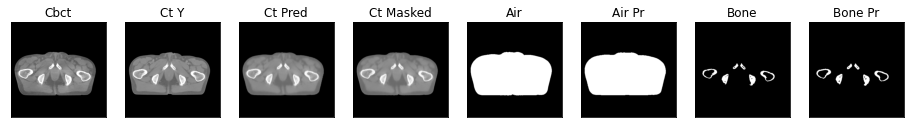

ssim score = 0.9044467806816101
psnr score = 27.04185676574707
snr score = 17.152332305908203
mae error = 0.015063402242958546
air dice score = 0.9935601653091587
bone dice score = 0.9459920409331155


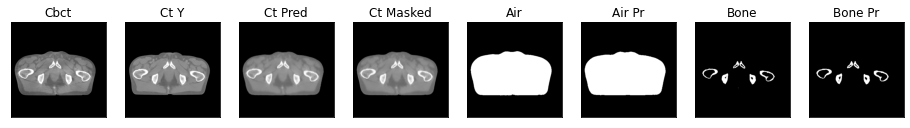

ssim score = 0.9033055305480957
psnr score = 26.869823455810547
snr score = 17.1431941986084
mae error = 0.016072586178779602
air dice score = 0.9934350532021748
bone dice score = 0.9425452800774553


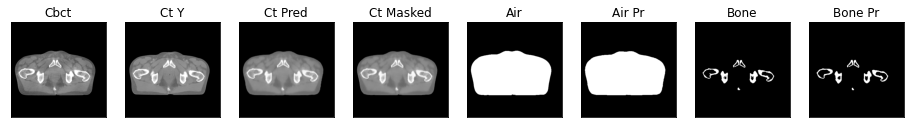

ssim score = 0.9012226462364197
psnr score = 26.92238998413086
snr score = 17.285011291503906
mae error = 0.016133733093738556
air dice score = 0.9934239633189946
bone dice score = 0.9289334627420583


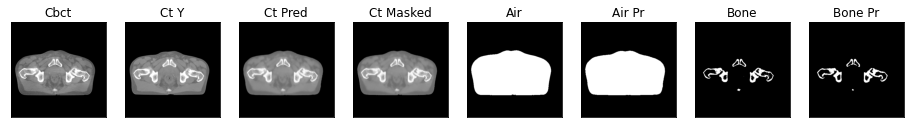

ssim score = 0.9010730385780334
psnr score = 27.170026779174805
snr score = 17.572952270507812
mae error = 0.015867197886109352
air dice score = 0.993361715865304
bone dice score = 0.9346549898957304


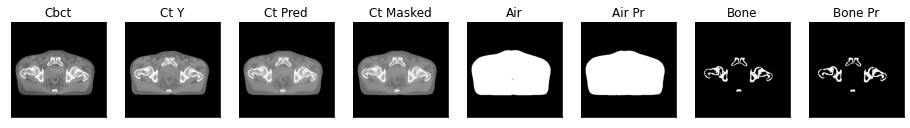

ssim score = 0.895793080329895
psnr score = 27.00628089904785
snr score = 17.545740127563477
mae error = 0.016546403989195824
air dice score = 0.9933334684200995
bone dice score = 0.9285773263980797


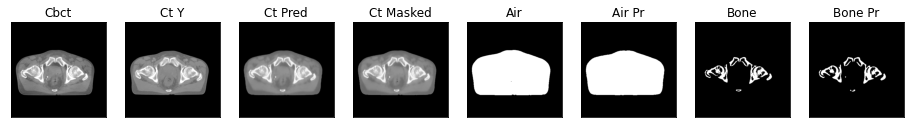

ssim score = 0.8933445811271667
psnr score = 26.990978240966797
snr score = 17.506380081176758
mae error = 0.016636623069643974
air dice score = 0.9921592218359124
bone dice score = 0.9303550059838025


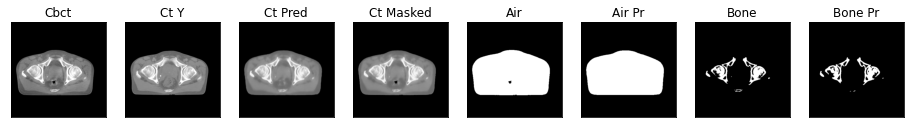

ssim score = 0.8950450420379639
psnr score = 27.39080238342285
snr score = 17.720666885375977
mae error = 0.015762409195303917
air dice score = 0.9924498881844931
bone dice score = 0.9362486828245851


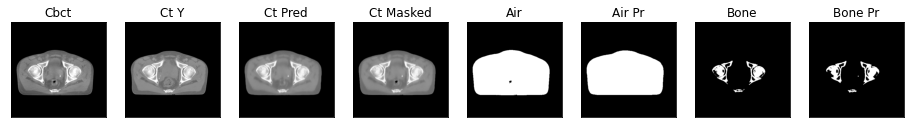

1it [00:03,  3.03s/it]

ssim score = 0.8976693153381348
psnr score = 27.52393913269043
snr score = 17.759248733520508
mae error = 0.015324369072914124
air dice score = 0.9935622317596633
bone dice score = 0.9442166491852368


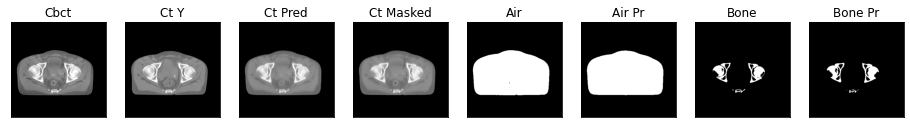

ssim score = 0.9026317596435547
psnr score = 27.869144439697266
snr score = 18.089170455932617
mae error = 0.014875628985464573
air dice score = 0.9932767345920908
bone dice score = 0.9402556227094


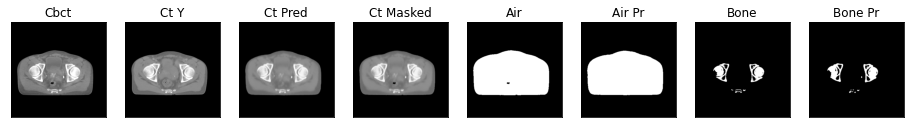

ssim score = 0.9072275757789612
psnr score = 28.00449562072754
snr score = 18.256792068481445
mae error = 0.014717310667037964
air dice score = 0.9938843994689422
bone dice score = 0.9530496751210118


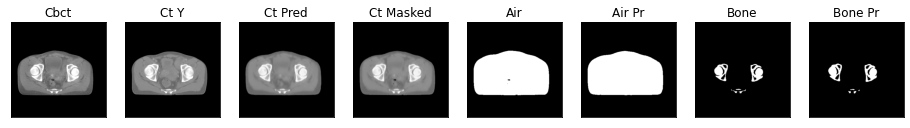

ssim score = 0.9080828428268433
psnr score = 27.741130828857422
snr score = 18.017139434814453
mae error = 0.01527177169919014
air dice score = 0.9910075165775947
bone dice score = 0.9612664907655804


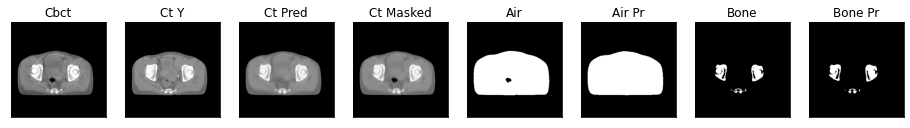

ssim score = 0.9143369197845459
psnr score = 27.84715461730957
snr score = 18.091238021850586
mae error = 0.01526127103716135
air dice score = 0.9883008593550707
bone dice score = 0.9645212644989252


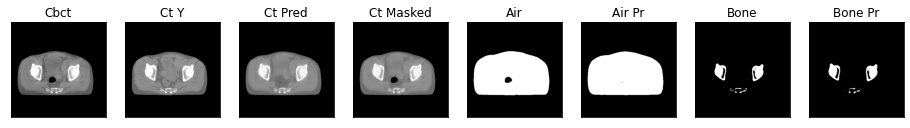

ssim score = 0.9116926789283752
psnr score = 27.91910171508789
snr score = 18.02122688293457
mae error = 0.015081260353326797
air dice score = 0.9874820483141625
bone dice score = 0.9425747529095136


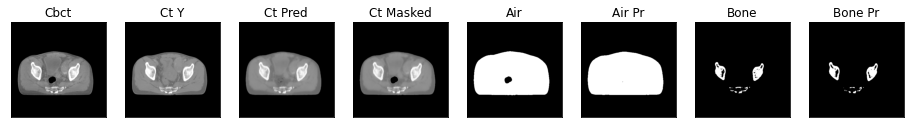

ssim score = 0.9106184840202332
psnr score = 27.81854820251465
snr score = 17.83501625061035
mae error = 0.014969557523727417
air dice score = 0.9875797174952384
bone dice score = 0.9274556526353263


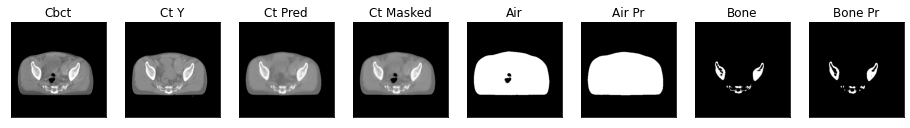

ssim score = 0.9024628400802612
psnr score = 27.029619216918945
snr score = 17.069570541381836
mae error = 0.016119278967380524
air dice score = 0.9890983321751334
bone dice score = 0.9355405066474098


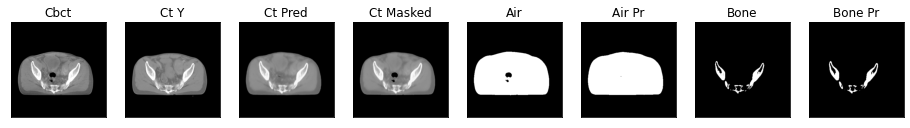

2it [00:05,  2.88s/it]

ssim score = 0.8988167643547058
psnr score = 26.342456817626953
snr score = 16.379865646362305
mae error = 0.017086878418922424
air dice score = 0.9865663621708906
bone dice score = 0.9353257621047778


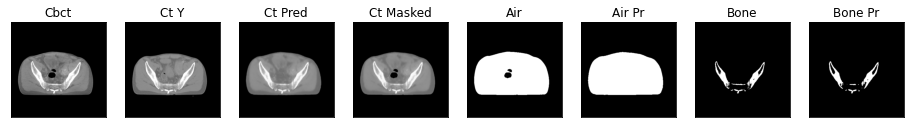

ssim score = 0.8948097229003906
psnr score = 25.885278701782227
snr score = 15.820926666259766
mae error = 0.01767079532146454
air dice score = 0.9838926025696633
bone dice score = 0.9168189014746458


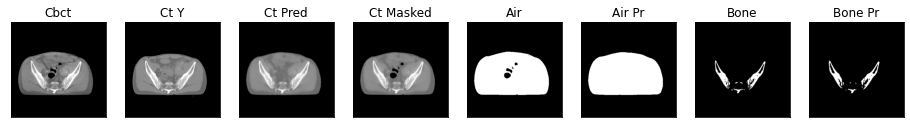

ssim score = 0.8926252722740173
psnr score = 25.455339431762695
snr score = 15.340303421020508
mae error = 0.018066370859742165
air dice score = 0.9838272517528125
bone dice score = 0.9163403346396541


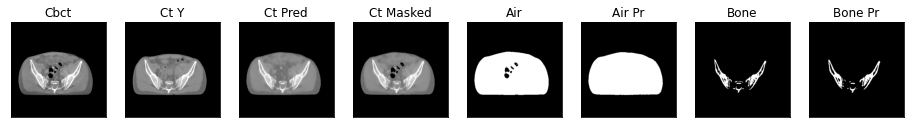

ssim score = 0.8915295600891113
psnr score = 24.902278900146484
snr score = 14.774934768676758
mae error = 0.01889834553003311
air dice score = 0.9867898112185137
bone dice score = 0.9215257531593594


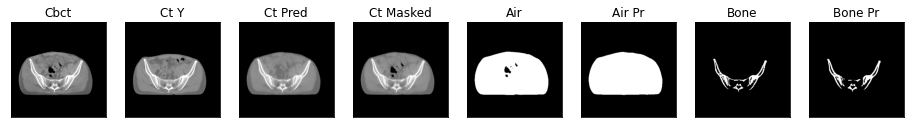

ssim score = 0.8875177502632141
psnr score = 24.4862003326416
snr score = 14.2940092086792
mae error = 0.019432250410318375
air dice score = 0.9895609211889512
bone dice score = 0.8998003992029301


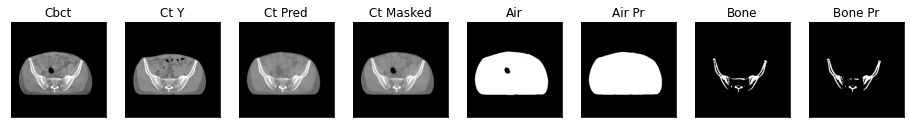

ssim score = 0.8839176893234253
psnr score = 24.122961044311523
snr score = 13.87134075164795
mae error = 0.019642146304249763
air dice score = 0.9900650434582512
bone dice score = 0.9140341791828841


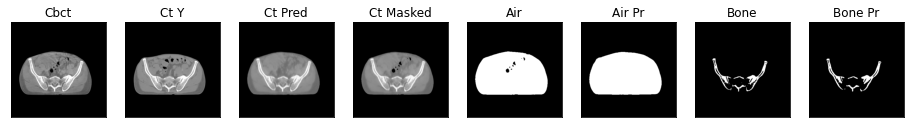

ssim score = 0.8853341937065125
psnr score = 24.018754959106445
snr score = 13.733707427978516
mae error = 0.01973884366452694
air dice score = 0.9924109477599019
bone dice score = 0.9236153010748929


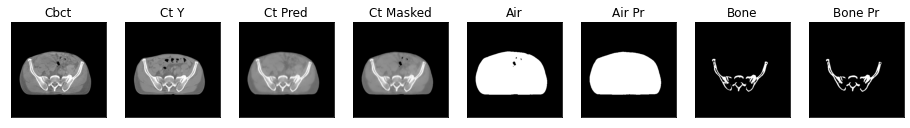

ssim score = 0.8853542804718018
psnr score = 23.844587326049805
snr score = 13.510974884033203
mae error = 0.02014504373073578
air dice score = 0.993335762391141
bone dice score = 0.9131242741008928


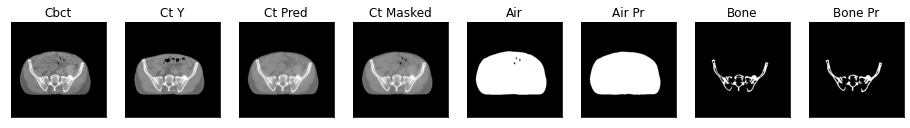

3it [00:07,  2.71s/it]

ssim score = 0.8856474161148071
psnr score = 23.699264526367188
snr score = 13.268651962280273
mae error = 0.020273812115192413
air dice score = 0.9941591570114026
bone dice score = 0.921789579382776


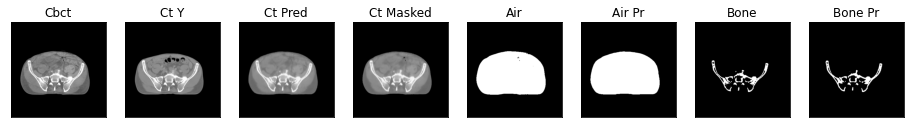

ssim score = 0.8879451155662537
psnr score = 23.930883407592773
snr score = 13.417535781860352
mae error = 0.019721530377864838
air dice score = 0.993632585607707
bone dice score = 0.9070238631257651


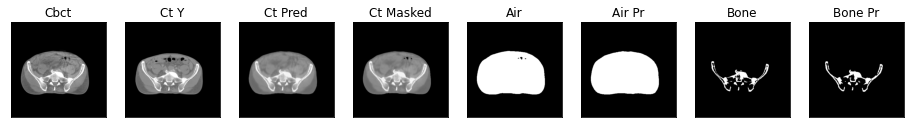

ssim score = 0.8867425322532654
psnr score = 24.002521514892578
snr score = 13.397987365722656
mae error = 0.019861217588186264
air dice score = 0.9926250402158133
bone dice score = 0.9197368421061433


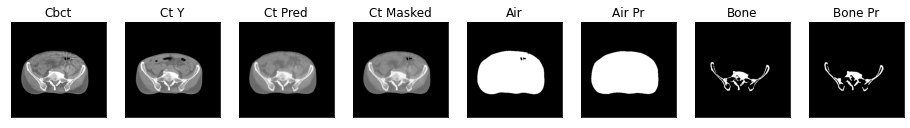

ssim score = 0.8874366283416748
psnr score = 23.93325424194336
snr score = 13.287612915039062
mae error = 0.020058665424585342
air dice score = 0.9911111111111223
bone dice score = 0.9225161424711257


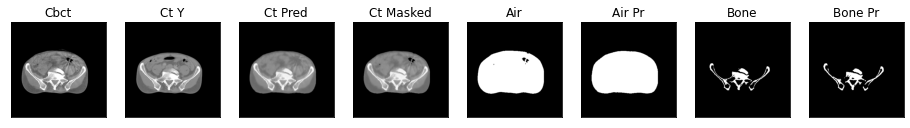

ssim score = 0.8735517859458923
psnr score = 23.957700729370117
snr score = 15.32985782623291
mae error = 0.021896537393331528
air dice score = 0.9930170479054313
bone dice score = 0.9779735682826314


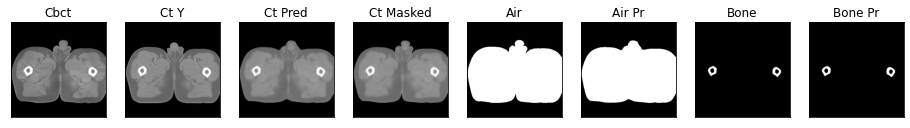

ssim score = 0.8779776096343994
psnr score = 24.553264617919922
snr score = 15.964680671691895
mae error = 0.020726200193166733
air dice score = 0.9938069939433803
bone dice score = 0.9773062186861978


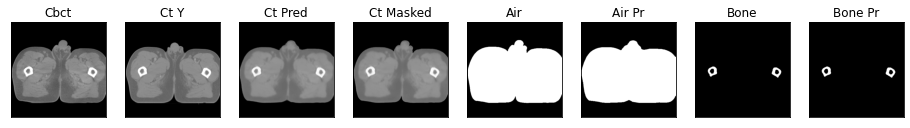

ssim score = 0.8870624899864197
psnr score = 25.293331146240234
snr score = 16.79219627380371
mae error = 0.019400497898459435
air dice score = 0.994596326487862
bone dice score = 0.9670433145017174


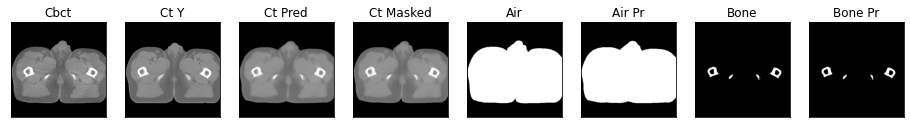

ssim score = 0.893509566783905
psnr score = 25.948984146118164
snr score = 17.61040687561035
mae error = 0.018652498722076416
air dice score = 0.9952827298903417
bone dice score = 0.9676593019537678


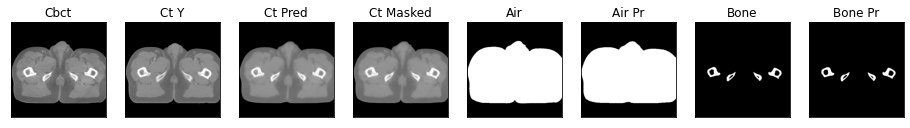

4it [00:10,  2.65s/it]

ssim score = 0.8955662250518799
psnr score = 26.436767578125
snr score = 18.226333618164062
mae error = 0.01813361980021
air dice score = 0.9957394340405817
bone dice score = 0.9576306046900092


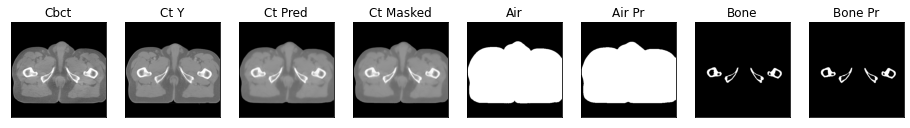

ssim score = 0.8968518972396851
psnr score = 26.934513092041016
snr score = 18.827316284179688
mae error = 0.017526255920529366
air dice score = 0.9954760485959968
bone dice score = 0.9471675611216794


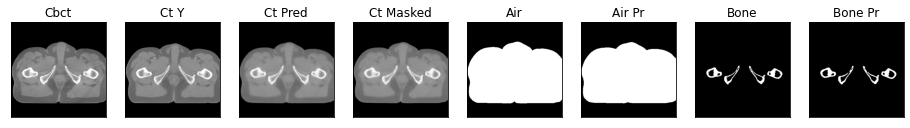

ssim score = 0.8993023037910461
psnr score = 27.385570526123047
snr score = 19.345476150512695
mae error = 0.017679354175925255
air dice score = 0.9956256740218379
bone dice score = 0.9402061855676592


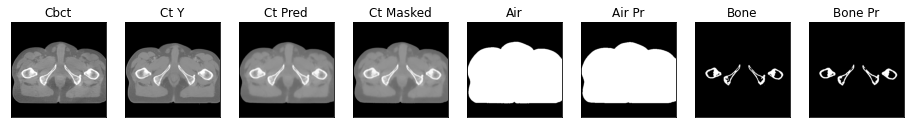

ssim score = 0.8991813659667969
psnr score = 27.587690353393555
snr score = 19.537700653076172
mae error = 0.017299270257353783
air dice score = 0.9955555018780446
bone dice score = 0.9550735067342956


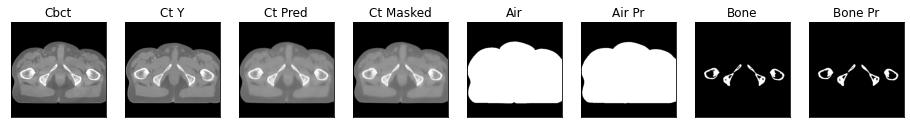

ssim score = 0.9016942381858826
psnr score = 27.694454193115234
snr score = 19.630802154541016
mae error = 0.017200086265802383
air dice score = 0.9955030441859091
bone dice score = 0.9582132564845799


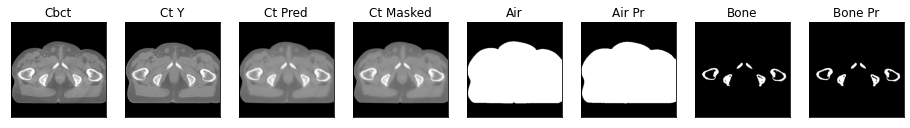

ssim score = 0.9046569466590881
psnr score = 27.786951065063477
snr score = 19.735301971435547
mae error = 0.01736730895936489
air dice score = 0.9954556671742704
bone dice score = 0.9435448577686701


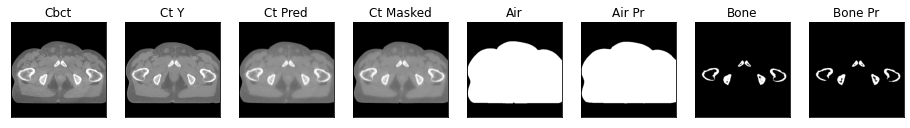

ssim score = 0.9054228067398071
psnr score = 27.658470153808594
snr score = 19.645902633666992
mae error = 0.017448464408516884
air dice score = 0.9952558189875501
bone dice score = 0.9520609319001785


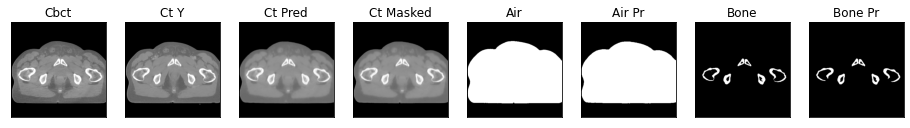

ssim score = 0.904335081577301
psnr score = 27.54283905029297
snr score = 19.67156219482422
mae error = 0.018114665523171425
air dice score = 0.9950673131293717
bone dice score = 0.95037622630774


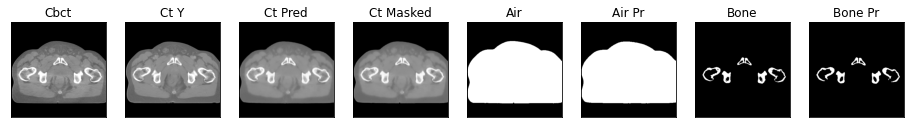

5it [00:12,  2.56s/it]

ssim score = 0.9031190276145935
psnr score = 27.62220001220703
snr score = 19.84560775756836
mae error = 0.018235230818390846
air dice score = 0.9949810509064867
bone dice score = 0.9498136842943803


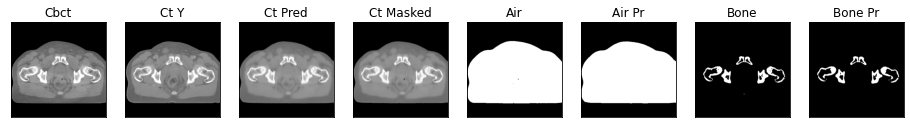

ssim score = 0.8930561542510986
psnr score = 26.961997985839844
snr score = 19.151363372802734
mae error = 0.01974186860024929
air dice score = 0.994336212576392
bone dice score = 0.9273063298942915


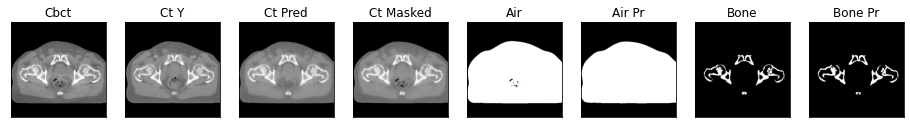

ssim score = 0.8898494839668274
psnr score = 26.91820526123047
snr score = 19.17975616455078
mae error = 0.01974744349718094
air dice score = 0.9927119014649123
bone dice score = 0.9185562860598514


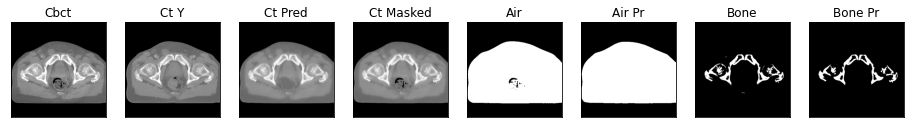

ssim score = 0.8863242864608765
psnr score = 26.702129364013672
snr score = 18.827587127685547
mae error = 0.019607676193118095
air dice score = 0.9931695903582198
bone dice score = 0.9001919385805253


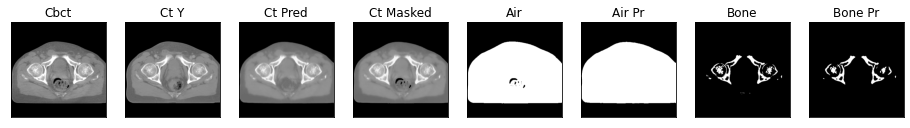

ssim score = 0.889303982257843
psnr score = 26.432758331298828
snr score = 18.37965202331543
mae error = 0.019140608608722687
air dice score = 0.9931500571337828
bone dice score = 0.8940410418321425


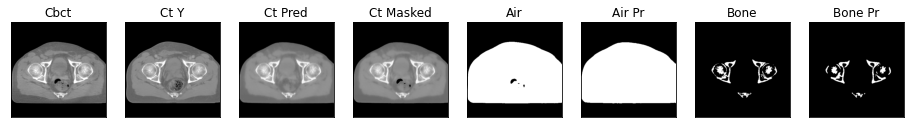

ssim score = 0.8874691724777222
psnr score = 25.89167594909668
snr score = 17.74797821044922
mae error = 0.019959725439548492
air dice score = 0.9948650072919379
bone dice score = 0.8676735798031145


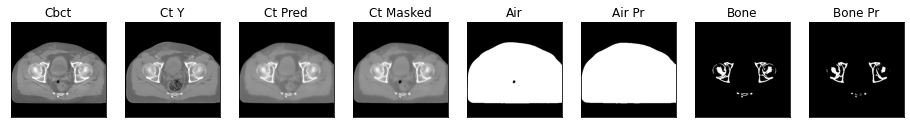

ssim score = 0.8879729509353638
psnr score = 25.732566833496094
snr score = 17.604562759399414
mae error = 0.020054958760738373
air dice score = 0.9956737130373269
bone dice score = 0.8953609319752927


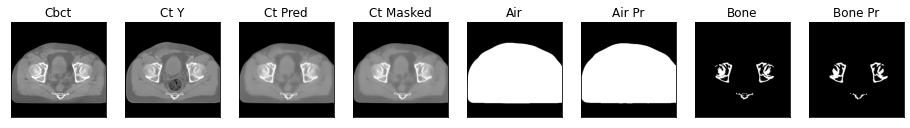

ssim score = 0.8779140710830688
psnr score = 25.653682708740234
snr score = 17.53571319580078
mae error = 0.02094854600727558
air dice score = 0.9958483117911683
bone dice score = 0.9193903782600129


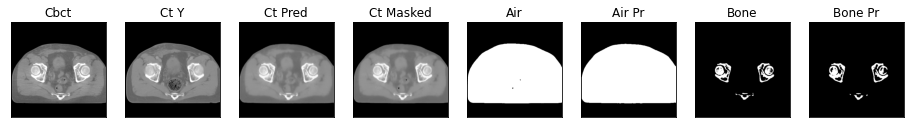

6it [00:15,  2.55s/it]

ssim score = 0.8851717710494995
psnr score = 26.0677490234375
snr score = 18.011367797851562
mae error = 0.020231394097208977
air dice score = 0.9955827260358255
bone dice score = 0.9463948998837532


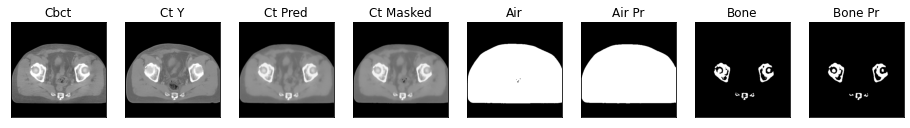

ssim score = 0.8883890509605408
psnr score = 26.83243751525879
snr score = 18.84614372253418
mae error = 0.019402822479605675
air dice score = 0.9954840759173583
bone dice score = 0.9628796400453156


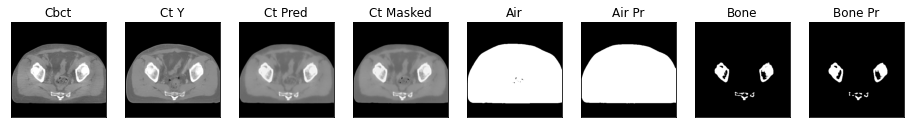

ssim score = 0.8909478783607483
psnr score = 26.469907760620117
snr score = 18.364501953125
mae error = 0.020005645230412483
air dice score = 0.9954533564194898
bone dice score = 0.9490501704827174


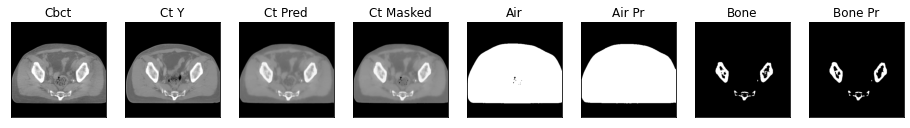

ssim score = 0.8865467309951782
psnr score = 26.049392700195312
snr score = 18.025615692138672
mae error = 0.02131071873009205
air dice score = 0.9943302401712788
bone dice score = 0.9579733243858907


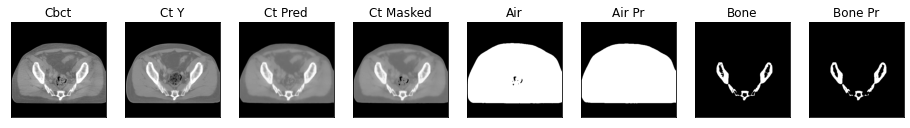

ssim score = 0.8869485259056091
psnr score = 26.298812866210938
snr score = 18.355186462402344
mae error = 0.021246233955025673
air dice score = 0.993207162903911
bone dice score = 0.9577147681702828


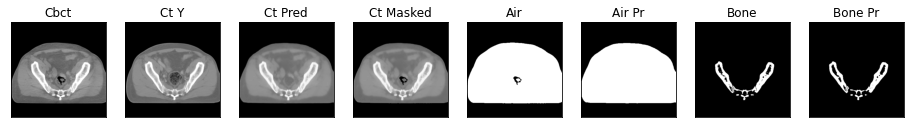

ssim score = 0.8717380166053772
psnr score = 25.801109313964844
snr score = 17.879039764404297
mae error = 0.02296462282538414
air dice score = 0.9931439886145702
bone dice score = 0.9462138789288743


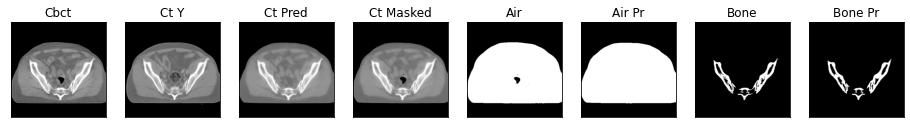

ssim score = 0.8749240636825562
psnr score = 25.965991973876953
snr score = 18.05645751953125
mae error = 0.022796785458922386
air dice score = 0.9956518262944608
bone dice score = 0.9541049030790044


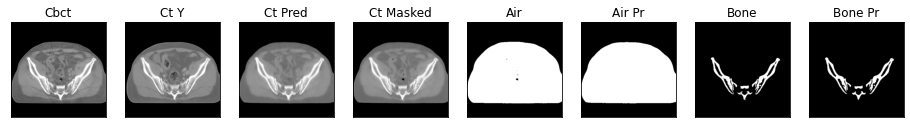

ssim score = 0.8223043084144592
psnr score = 21.263221740722656
snr score = 11.143431663513184
mae error = 0.0318128801882267
air dice score = 0.976585781183504
bone dice score = 0.9621860336747947


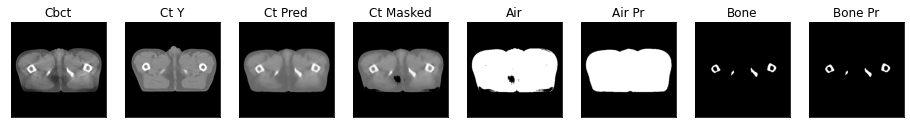

7it [00:17,  2.55s/it]

ssim score = 0.810585081577301
psnr score = 20.862079620361328
snr score = 10.955265998840332
mae error = 0.03439624607563019
air dice score = 0.9765754484181277
bone dice score = 0.9305461901566522


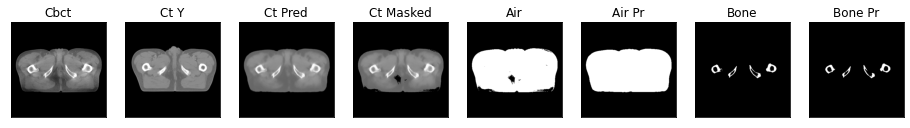

ssim score = 0.8059800267219543
psnr score = 20.838621139526367
snr score = 11.062950134277344
mae error = 0.03504430502653122
air dice score = 0.97633569610054
bone dice score = 0.8984003458733593


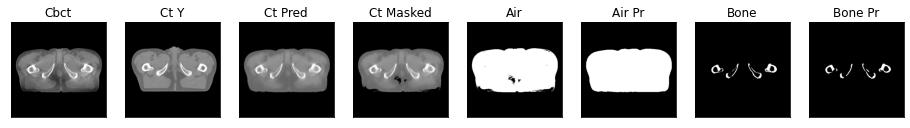

ssim score = 0.8079301714897156
psnr score = 21.129592895507812
snr score = 11.424324035644531
mae error = 0.034087151288986206
air dice score = 0.9741336701631298
bone dice score = 0.8909434755223589


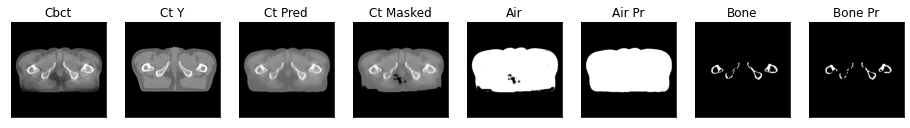

ssim score = 0.8080952763557434
psnr score = 21.181968688964844
snr score = 11.524267196655273
mae error = 0.03409639373421669
air dice score = 0.975370625165175
bone dice score = 0.8921330089235172


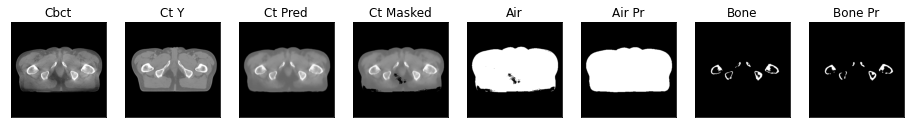

ssim score = 0.808885931968689
psnr score = 21.34814453125
snr score = 11.696056365966797
mae error = 0.03341854363679886
air dice score = 0.9757794265890715
bone dice score = 0.8946045252389363


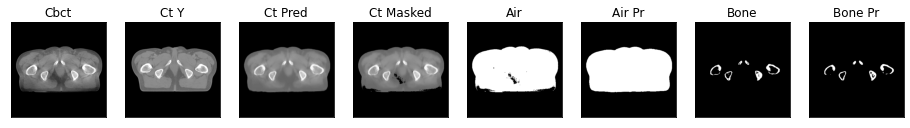

ssim score = 0.8097598552703857
psnr score = 21.426210403442383
snr score = 11.767620086669922
mae error = 0.03293541073799133
air dice score = 0.9766831642855415
bone dice score = 0.9258194364591562


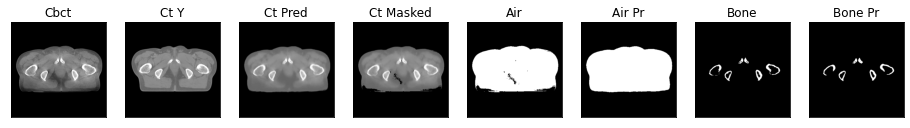

ssim score = 0.8110866546630859
psnr score = 21.28932762145996
snr score = 11.644845962524414
mae error = 0.03311853110790253
air dice score = 0.9782150766073329
bone dice score = 0.9283858998157999


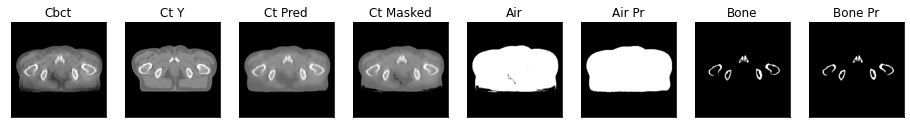

ssim score = 0.8112417459487915
psnr score = 21.22677230834961
snr score = 11.640300750732422
mae error = 0.03390532732009888
air dice score = 0.979332501727545
bone dice score = 0.9144008056409131


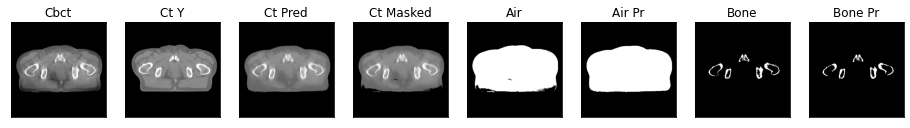

8it [00:20,  2.47s/it]

ssim score = 0.8041038513183594
psnr score = 21.04595184326172
snr score = 11.558037757873535
mae error = 0.03562160208821297
air dice score = 0.9798948622193745
bone dice score = 0.8830533355099812


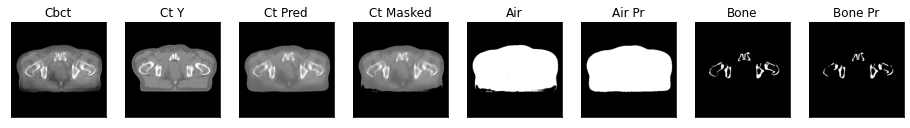

ssim score = 0.7922062873840332
psnr score = 20.85395622253418
snr score = 11.40186882019043
mae error = 0.03702123835682869
air dice score = 0.9796531647154755
bone dice score = 0.8838430645677503


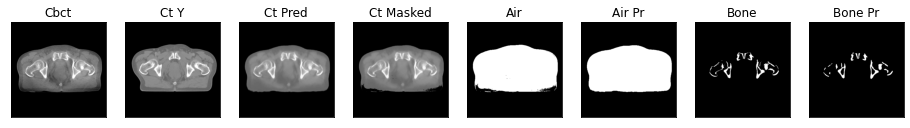

ssim score = 0.7803583741188049
psnr score = 20.736675262451172
snr score = 11.317298889160156
mae error = 0.037383273243904114
air dice score = 0.9784701589086267
bone dice score = 0.8526785714306266


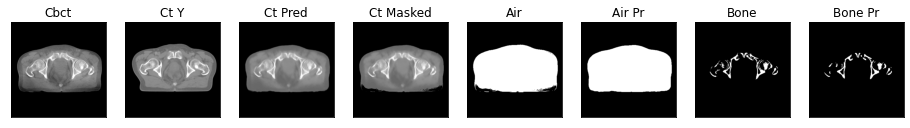

ssim score = 0.7819145321846008
psnr score = 20.72348403930664
snr score = 11.42092514038086
mae error = 0.037841107696294785
air dice score = 0.9789206292615723
bone dice score = 0.8518675123347165


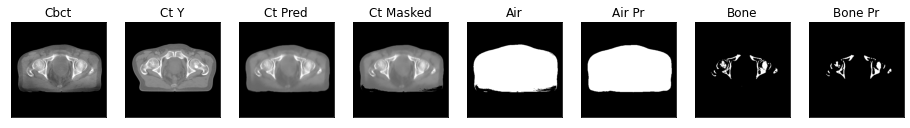

ssim score = 0.7854103446006775
psnr score = 20.66826629638672
snr score = 11.349715232849121
mae error = 0.03800387680530548
air dice score = 0.9782848992690513
bone dice score = 0.8408304498294931


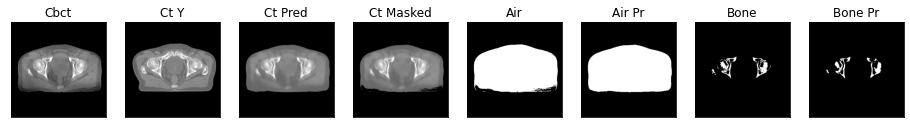

ssim score = 0.801852822303772
psnr score = 21.26132583618164
snr score = 11.743613243103027
mae error = 0.034385520964860916
air dice score = 0.977311021761826
bone dice score = 0.8739412057818644


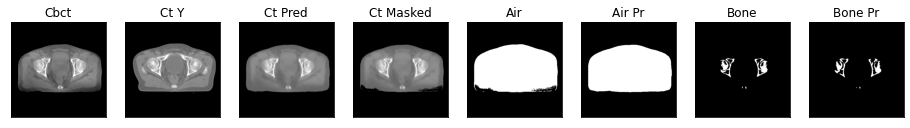

ssim score = 0.8179230690002441
psnr score = 21.9920711517334
snr score = 12.303966522216797
mae error = 0.0310200322419405
air dice score = 0.9770948875219418
bone dice score = 0.9174956114699021


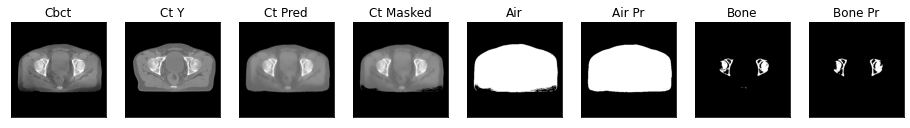

ssim score = 0.8266546726226807
psnr score = 22.428020477294922
snr score = 12.754085540771484
mae error = 0.029320405796170235
air dice score = 0.9758762758166776
bone dice score = 0.9365959172646128


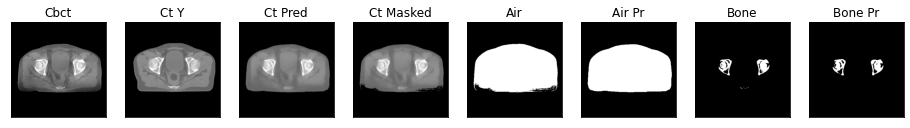

9it [00:22,  2.49s/it]

ssim score = 0.8316788077354431
psnr score = 22.61650848388672
snr score = 13.02440071105957
mae error = 0.02906207926571369
air dice score = 0.9749286279671867
bone dice score = 0.9509127789053291


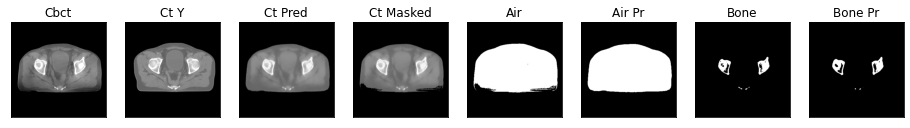

ssim score = 0.8306601643562317
psnr score = 22.52465057373047
snr score = 13.024715423583984
mae error = 0.02976926788687706
air dice score = 0.9738769206188819
bone dice score = 0.932164282419133


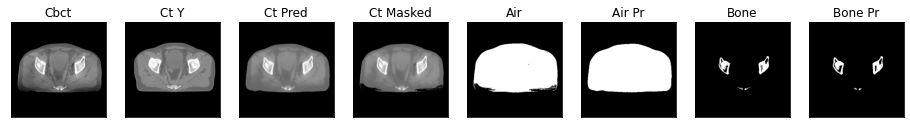

ssim score = 0.8262536525726318
psnr score = 22.803043365478516
snr score = 13.239681243896484
mae error = 0.02861219085752964
air dice score = 0.9759304795396068
bone dice score = 0.9388926401090666


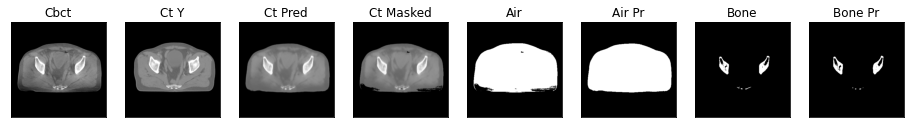

ssim score = 0.8326661586761475
psnr score = 23.25487518310547
snr score = 13.655119895935059
mae error = 0.02697264775633812
air dice score = 0.9750323426650576
bone dice score = 0.9505454545463538


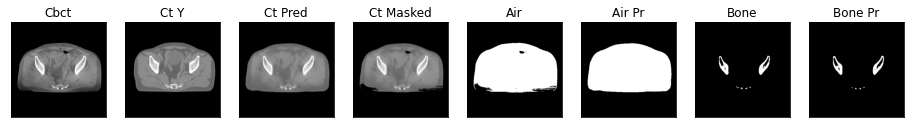

ssim score = 0.8288852572441101
psnr score = 23.11954689025879
snr score = 13.557538032531738
mae error = 0.02811608463525772
air dice score = 0.975549305677645
bone dice score = 0.9169241331974438


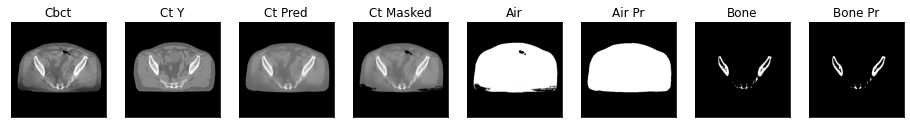

ssim score = 0.8223152160644531
psnr score = 22.86474609375
snr score = 13.433242797851562
mae error = 0.029283948242664337
air dice score = 0.9768704852628637
bone dice score = 0.9202057310812608


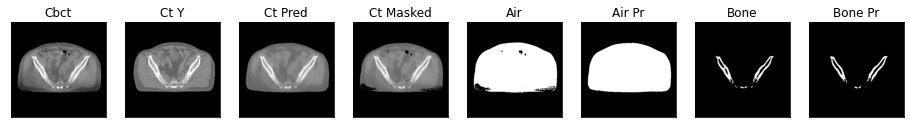

ssim score = 0.8246846795082092
psnr score = 22.853199005126953
snr score = 13.439441680908203
mae error = 0.02934063784778118
air dice score = 0.9776900226537699
bone dice score = 0.8968467754730336


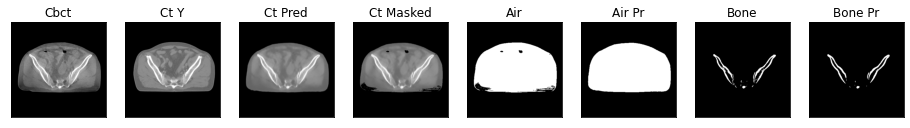

ssim score = 0.826907217502594
psnr score = 23.163740158081055
snr score = 13.738714218139648
mae error = 0.028488708660006523
air dice score = 0.9793401226320955
bone dice score = 0.9080420766897176


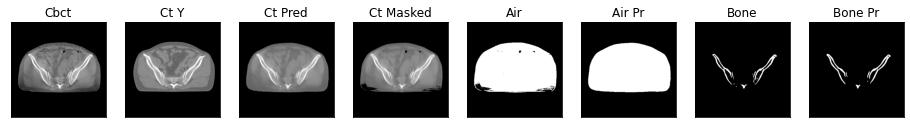

10it [00:25,  2.49s/it]

ssim score = 0.8290931582450867
psnr score = 23.225032806396484
snr score = 13.79926586151123
mae error = 0.028075452893972397
air dice score = 0.9803778811663348
bone dice score = 0.8873501097806561


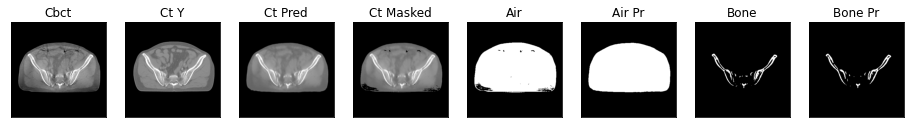

ssim score = 0.8779603242874146
psnr score = 24.546785354614258
snr score = 14.980920791625977
mae error = 0.019752979278564453
air dice score = 0.9940205885680166
bone dice score = 0.9545280855959294


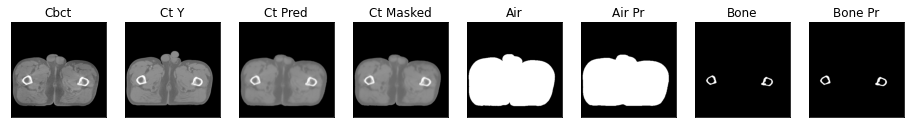

ssim score = 0.8762272596359253
psnr score = 24.722936630249023
snr score = 15.221464157104492
mae error = 0.019755639135837555
air dice score = 0.9942210469630403
bone dice score = 0.93333333333571


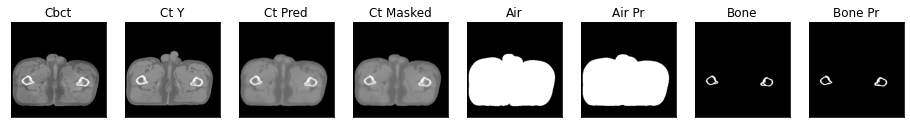

ssim score = 0.8861283659934998
psnr score = 26.595230102539062
snr score = 17.232967376708984
mae error = 0.018192609772086143
air dice score = 0.9934660241193475
bone dice score = 0.9440543601371675


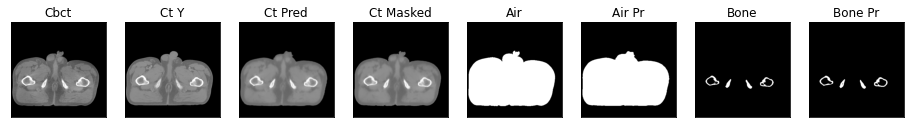

ssim score = 0.8849726319313049
psnr score = 26.37458038330078
snr score = 17.13381004333496
mae error = 0.018766408786177635
air dice score = 0.9934388693695524
bone dice score = 0.9264867237233599


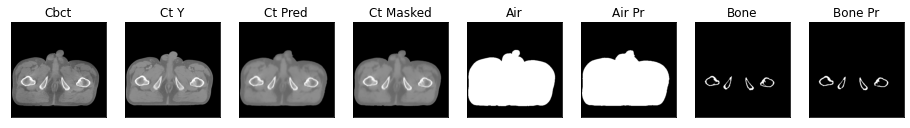

ssim score = 0.8798174262046814
psnr score = 26.086078643798828
snr score = 16.86948013305664
mae error = 0.019087709486484528
air dice score = 0.993501532063052
bone dice score = 0.9047399907983262


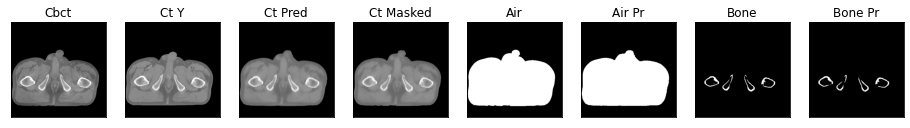

ssim score = 0.8815024495124817
psnr score = 25.987430572509766
snr score = 16.766437530517578
mae error = 0.019013142213225365
air dice score = 0.9939222392577789
bone dice score = 0.9035916824216846


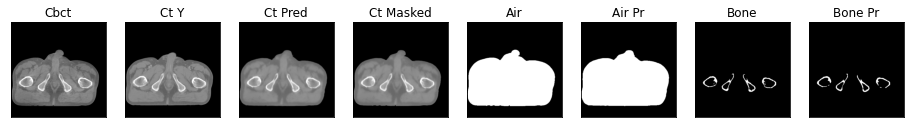

ssim score = 0.8814973831176758
psnr score = 25.502756118774414
snr score = 16.28801727294922
mae error = 0.019727667793631554
air dice score = 0.9936959597547605
bone dice score = 0.8944580277120119


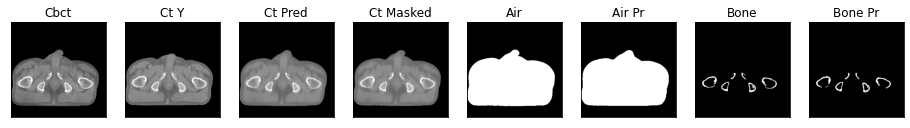

11it [00:27,  2.43s/it]

ssim score = 0.8801840543746948
psnr score = 25.256214141845703
snr score = 16.019920349121094
mae error = 0.01966809295117855
air dice score = 0.9942611529650754
bone dice score = 0.9018123879724793


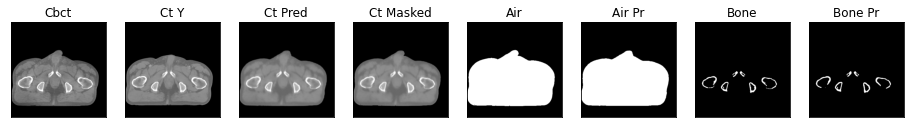

ssim score = 0.8808809518814087
psnr score = 25.234088897705078
snr score = 16.01470184326172
mae error = 0.019590256735682487
air dice score = 0.9949073452662038
bone dice score = 0.9218983557563173


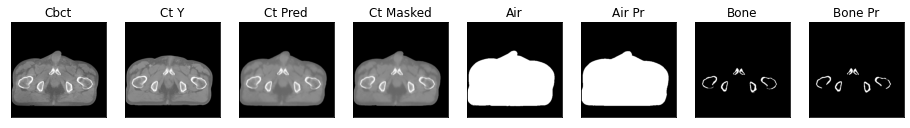

ssim score = 0.8819726705551147
psnr score = 25.62493133544922
snr score = 16.474140167236328
mae error = 0.019218694418668747
air dice score = 0.9951814103885026
bone dice score = 0.901291989665783


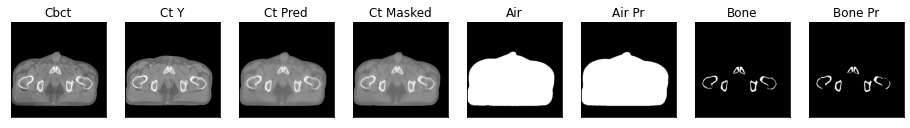

ssim score = 0.8833020329475403
psnr score = 26.107702255249023
snr score = 17.038270950317383
mae error = 0.018790623173117638
air dice score = 0.9949375149247831
bone dice score = 0.9027645376564544


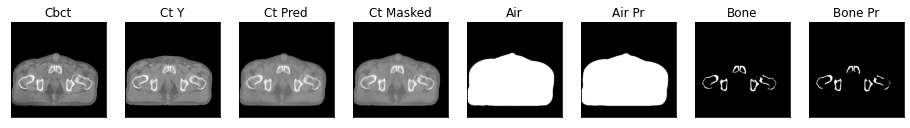

ssim score = 0.8850454092025757
psnr score = 26.678592681884766
snr score = 17.659862518310547
mae error = 0.01831914484500885
air dice score = 0.9946317303083603
bone dice score = 0.878197320342902


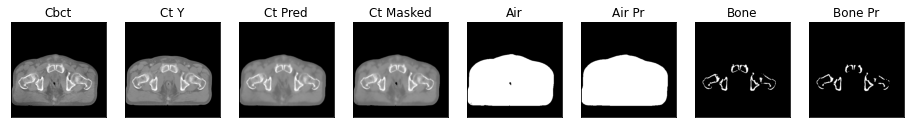

ssim score = 0.8878259658813477
psnr score = 26.990463256835938
snr score = 18.088003158569336
mae error = 0.01814112439751625
air dice score = 0.9945828992707793
bone dice score = 0.8581255374053006


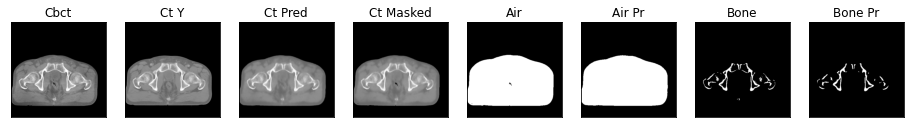

ssim score = 0.8870381116867065
psnr score = 27.13019371032715
snr score = 18.189496994018555
mae error = 0.017879799008369446
air dice score = 0.9929947178562283
bone dice score = 0.8390591148276221


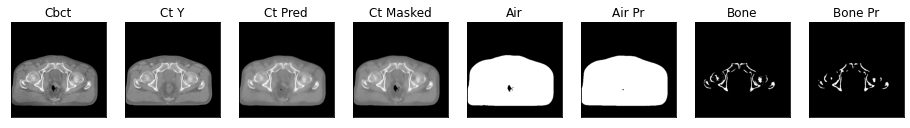

ssim score = 0.8820170760154724
psnr score = 27.081430435180664
snr score = 18.045063018798828
mae error = 0.0177318025380373
air dice score = 0.9888587970095609
bone dice score = 0.8076866656915405


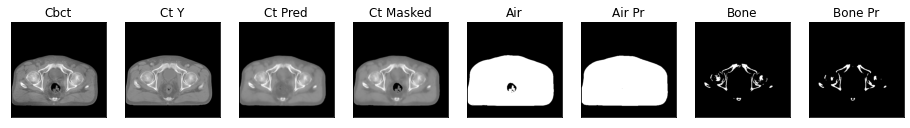

12it [00:29,  2.44s/it]

ssim score = 0.8869549036026001
psnr score = 27.27825355529785
snr score = 18.082130432128906
mae error = 0.01702101342380047
air dice score = 0.986524273427639
bone dice score = 0.8221859706394383


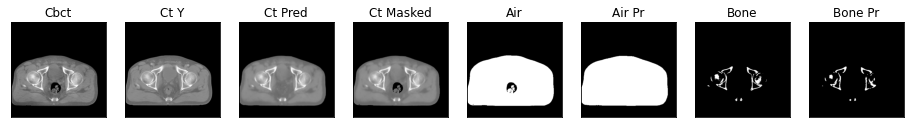

ssim score = 0.8843885064125061
psnr score = 26.2412052154541
snr score = 16.92865562438965
mae error = 0.017919540405273438
air dice score = 0.9887877762835572
bone dice score = 0.8461398065368473


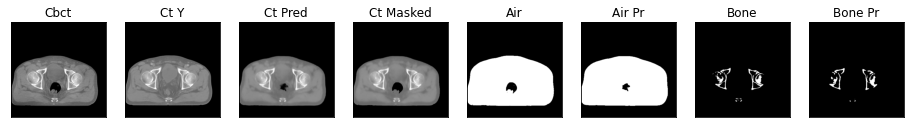

ssim score = 0.8816222548484802
psnr score = 25.550865173339844
snr score = 16.193220138549805
mae error = 0.01855151169002056
air dice score = 0.9903156563555666
bone dice score = 0.8680461329737441


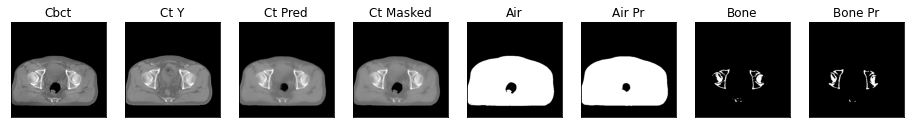

ssim score = 0.8765448331832886
psnr score = 24.79600715637207
snr score = 15.445033073425293
mae error = 0.020176313817501068
air dice score = 0.9903204021910488
bone dice score = 0.916463116757589


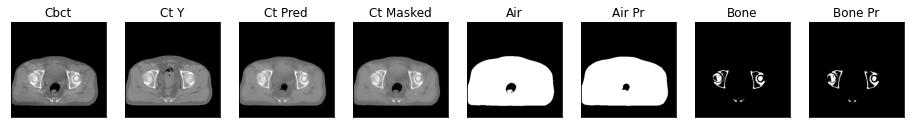

ssim score = 0.8766074776649475
psnr score = 24.146764755249023
snr score = 14.825897216796875
mae error = 0.021621866151690483
air dice score = 0.9915737153472252
bone dice score = 0.9369722557307453


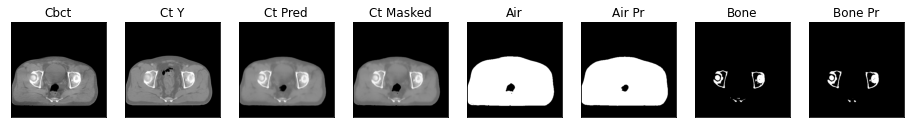

ssim score = 0.8823720812797546
psnr score = 24.823631286621094
snr score = 15.460176467895508
mae error = 0.020211732015013695
air dice score = 0.991381901994195
bone dice score = 0.9237867395775156


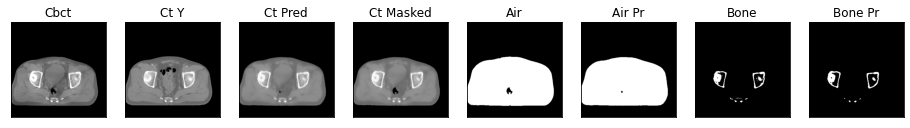

ssim score = 0.8843446373939514
psnr score = 24.751310348510742
snr score = 15.297652244567871
mae error = 0.019523847848176956
air dice score = 0.9925960747443945
bone dice score = 0.9158262218790569


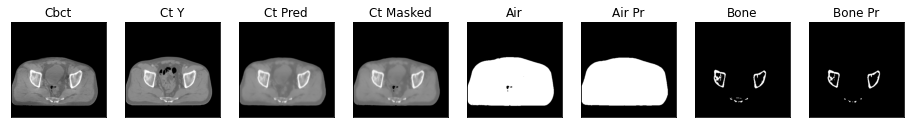

ssim score = 0.8859508633613586
psnr score = 24.875022888183594
snr score = 15.35563850402832
mae error = 0.019229739904403687
air dice score = 0.9910430071114197
bone dice score = 0.9255042939899041


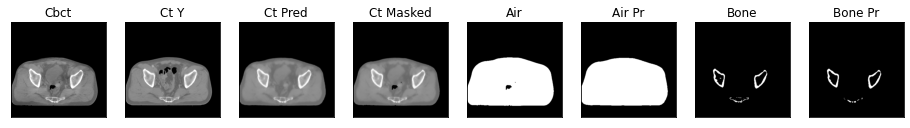

13it [00:32,  2.46s/it]

ssim score = 0.8858175277709961
psnr score = 25.16433334350586
snr score = 15.644644737243652
mae error = 0.01906241476535797
air dice score = 0.9905090595340892
bone dice score = 0.9255150554688235


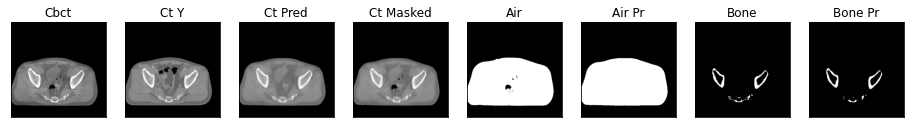

ssim score = 0.8812722563743591
psnr score = 25.2659969329834
snr score = 15.82247543334961
mae error = 0.019687170162796974
air dice score = 0.9892728823635939
bone dice score = 0.9120815138295184


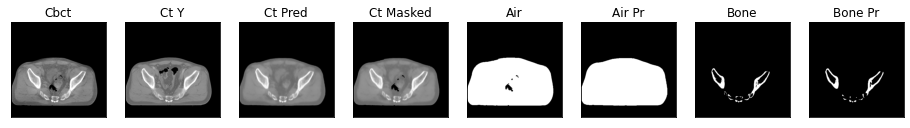

ssim score = 0.8856340646743774
psnr score = 25.37473487854004
snr score = 15.966797828674316
mae error = 0.019245611503720284
air dice score = 0.9881684561659646
bone dice score = 0.9217252396176554


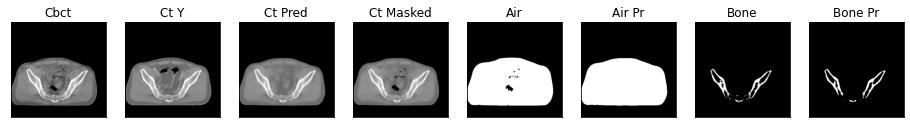

ssim score = 0.8877553939819336
psnr score = 25.584096908569336
snr score = 16.11446189880371
mae error = 0.018596908077597618
air dice score = 0.9893138849537495
bone dice score = 0.8976176971086555


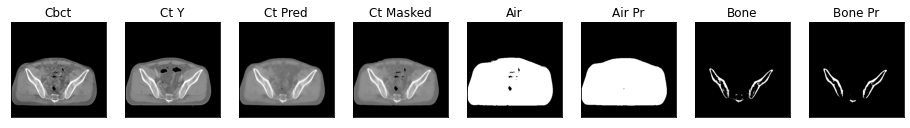

ssim score = 0.884903609752655
psnr score = 25.256542205810547
snr score = 15.72564697265625
mae error = 0.01909102126955986
air dice score = 0.9887920298879302
bone dice score = 0.8929154908674749


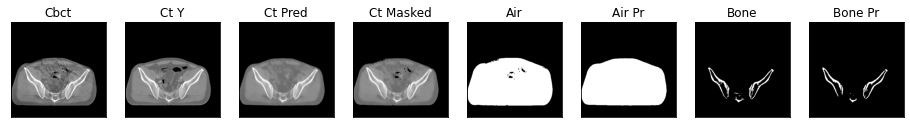

ssim score = 0.8261227607727051
psnr score = 22.945077896118164
snr score = 14.642382621765137
mae error = 0.028385618701577187
air dice score = 0.9938904595332827
bone dice score = 0.9662710805756942


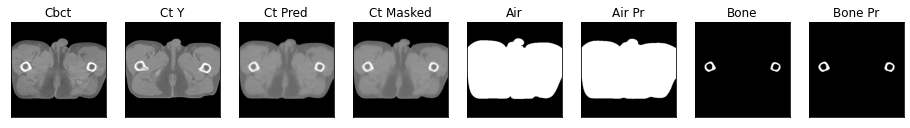

ssim score = 0.8157268166542053
psnr score = 22.58102035522461
snr score = 14.38261604309082
mae error = 0.029741734266281128
air dice score = 0.9945280356302914
bone dice score = 0.9624611910820643


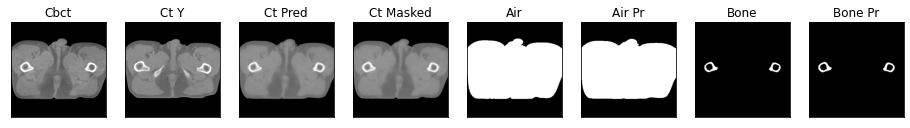

ssim score = 0.8088855147361755
psnr score = 22.18332290649414
snr score = 14.11287784576416
mae error = 0.03174111619591713
air dice score = 0.9950363958058761
bone dice score = 0.9417101383546902


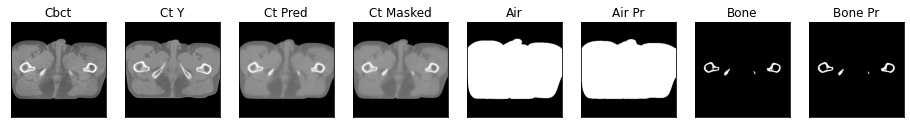

14it [00:34,  2.41s/it]

ssim score = 0.7986533045768738
psnr score = 21.81107521057129
snr score = 13.772918701171875
mae error = 0.03261817991733551
air dice score = 0.9948536945025169
bone dice score = 0.9498338870440227


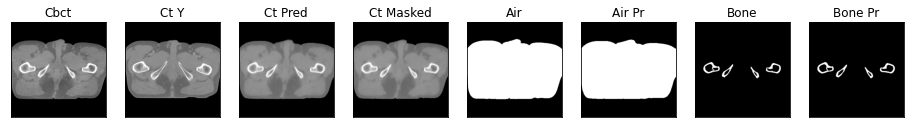

ssim score = 0.7898029685020447
psnr score = 21.632118225097656
snr score = 13.624198913574219
mae error = 0.03374846652150154
air dice score = 0.9947609344083195
bone dice score = 0.9223460026225042


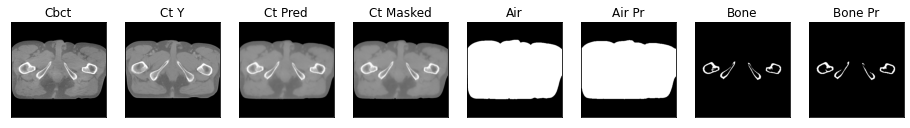

ssim score = 0.784318208694458
psnr score = 21.546600341796875
snr score = 13.573098182678223
mae error = 0.03477881848812103
air dice score = 0.9947187141217023
bone dice score = 0.9221650288578667


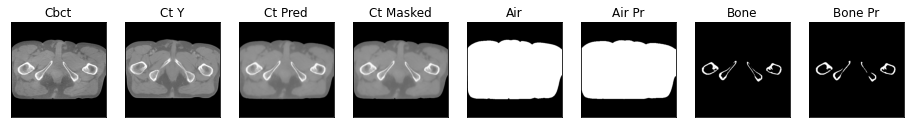

ssim score = 0.7778280377388
psnr score = 21.276878356933594
snr score = 13.323686599731445
mae error = 0.03603075072169304
air dice score = 0.9949820115384419
bone dice score = 0.9264966589400451


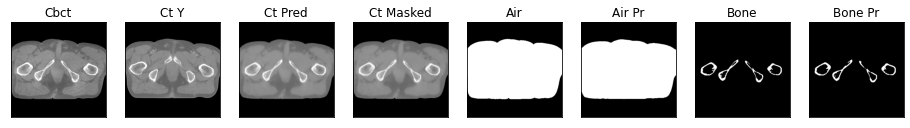

ssim score = 0.7773012518882751
psnr score = 21.341238021850586
snr score = 13.427119255065918
mae error = 0.03545995429158211
air dice score = 0.9954600910328026
bone dice score = 0.9187941336241336


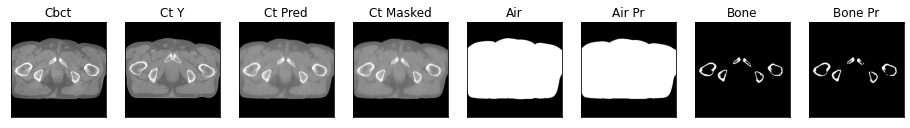

ssim score = 0.7780271172523499
psnr score = 21.502687454223633
snr score = 13.637248039245605
mae error = 0.03506631404161453
air dice score = 0.9958272933747303
bone dice score = 0.9307863404431403


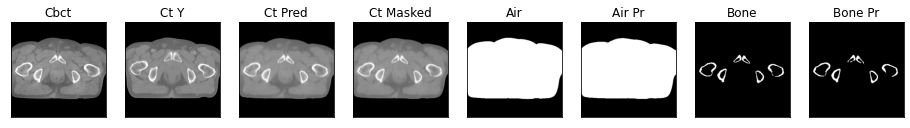

ssim score = 0.7691326141357422
psnr score = 21.316287994384766
snr score = 13.473459243774414
mae error = 0.036817312240600586
air dice score = 0.9956783065059984
bone dice score = 0.9294563843245328


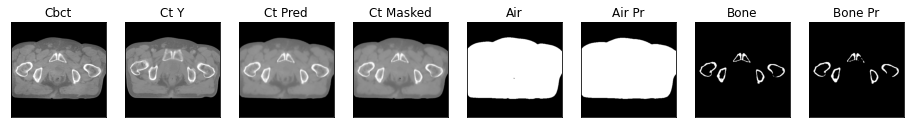

ssim score = 0.7562676668167114
psnr score = 21.226797103881836
snr score = 13.42674732208252
mae error = 0.038342494517564774
air dice score = 0.9956102664819614
bone dice score = 0.9117891487603965


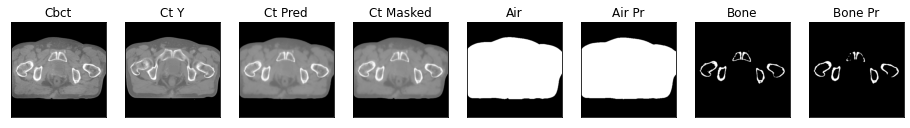

15it [00:37,  2.45s/it]

ssim score = 0.7583795785903931
psnr score = 21.271181106567383
snr score = 13.529470443725586
mae error = 0.03842930868268013
air dice score = 0.9952907715441401
bone dice score = 0.9100021791249727


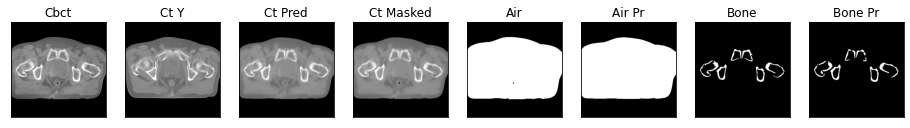

ssim score = 0.7535755634307861
psnr score = 21.060474395751953
snr score = 13.243392944335938
mae error = 0.04040440544486046
air dice score = 0.9952046742786671
bone dice score = 0.9032002377895254


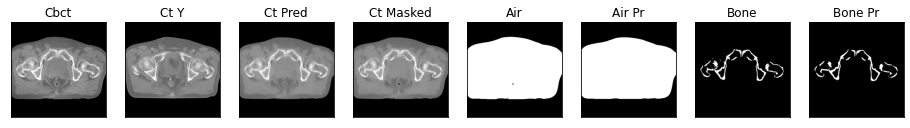

ssim score = 0.7589082717895508
psnr score = 20.971115112304688
snr score = 13.04681396484375
mae error = 0.041033562272787094
air dice score = 0.9952977873994696
bone dice score = 0.8709036742813218


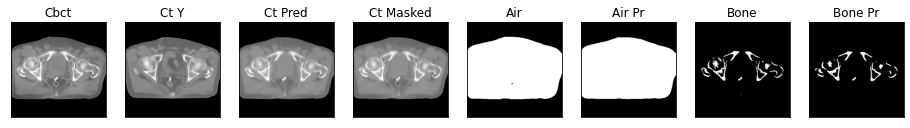

ssim score = 0.7702102065086365
psnr score = 21.126853942871094
snr score = 13.079465866088867
mae error = 0.040461465716362
air dice score = 0.9950832469212066
bone dice score = 0.8361054766750903


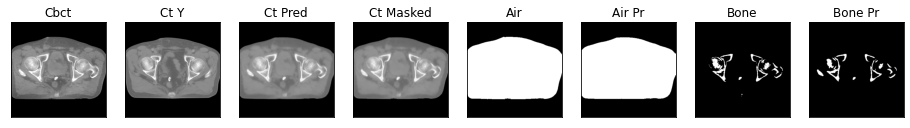

ssim score = 0.7744061946868896
psnr score = 21.370933532714844
snr score = 13.211115837097168
mae error = 0.03891714662313461
air dice score = 0.9952707910039963
bone dice score = 0.8623545445029631


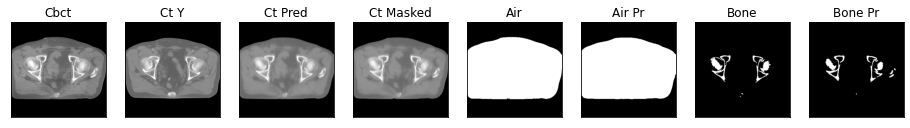

ssim score = 0.7733561396598816
psnr score = 21.69178009033203
snr score = 13.48131275177002
mae error = 0.03624766692519188
air dice score = 0.9951993443006878
bone dice score = 0.893083087306062


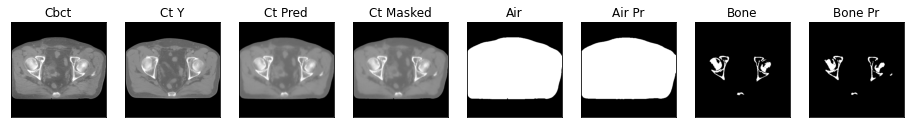

ssim score = 0.7724801301956177
psnr score = 21.518306732177734
snr score = 13.339994430541992
mae error = 0.03717566281557083
air dice score = 0.9953584018801437
bone dice score = 0.9008749584682592


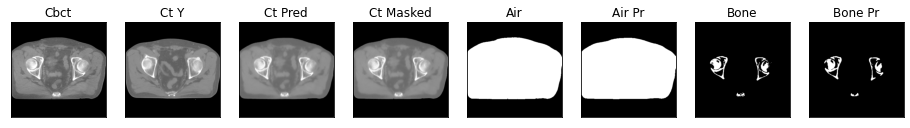

ssim score = 0.7720108032226562
psnr score = 21.249004364013672
snr score = 13.084169387817383
mae error = 0.03839803487062454
air dice score = 0.9952323070205488
bone dice score = 0.9124183006546355


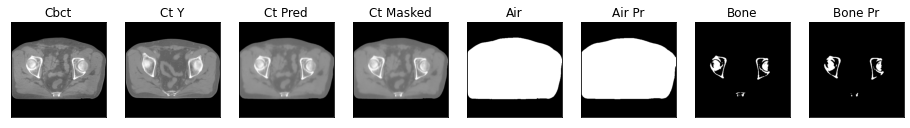

16it [00:39,  2.41s/it]

ssim score = 0.7705637812614441
psnr score = 20.951297760009766
snr score = 12.64497184753418
mae error = 0.03978145495057106
air dice score = 0.995053439460982
bone dice score = 0.9254293107512886


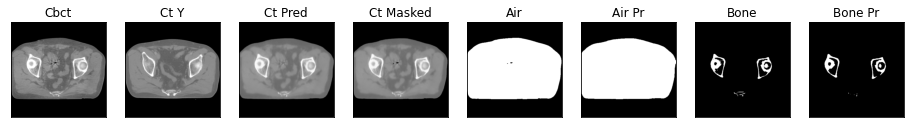

ssim score = 0.7783891558647156
psnr score = 21.038421630859375
snr score = 12.6727876663208
mae error = 0.03921350836753845
air dice score = 0.9952714024197568
bone dice score = 0.9203077768628701


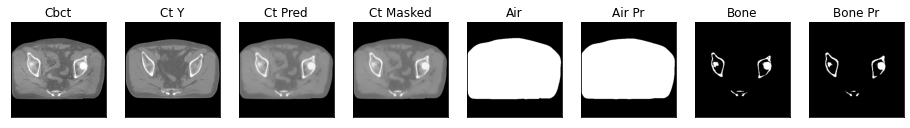

ssim score = 0.7788353562355042
psnr score = 21.35873031616211
snr score = 13.018742561340332
mae error = 0.03701658174395561
air dice score = 0.9952172036823964
bone dice score = 0.9008154750635158


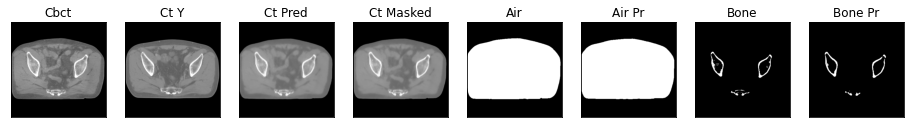

ssim score = 0.7759201526641846
psnr score = 21.370616912841797
snr score = 13.103442192077637
mae error = 0.036866527050733566
air dice score = 0.9946243039317343
bone dice score = 0.9132662073853866


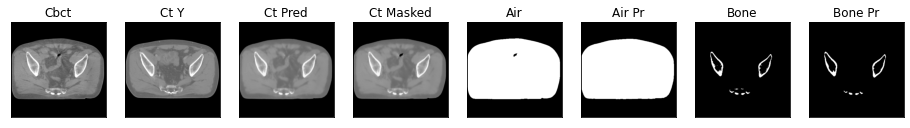

ssim score = 0.7687481045722961
psnr score = 21.122739791870117
snr score = 12.984796524047852
mae error = 0.0384245403110981
air dice score = 0.9941163995516138
bone dice score = 0.9187767181861431


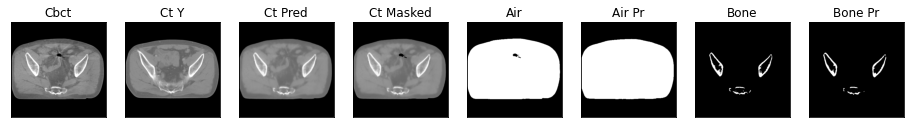

ssim score = 0.7617973685264587
psnr score = 21.048707962036133
snr score = 12.944725036621094
mae error = 0.0389382503926754
air dice score = 0.99353070175439
bone dice score = 0.9099683305698995


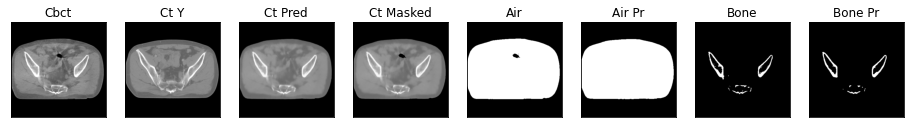

ssim score = 0.7504345774650574
psnr score = 20.93598175048828
snr score = 12.80220890045166
mae error = 0.03971147909760475
air dice score = 0.9947469163359315
bone dice score = 0.8980148883387343


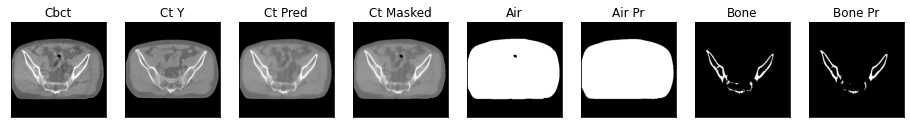

ssim score = 0.7479930520057678
psnr score = 21.079254150390625
snr score = 12.88210678100586
mae error = 0.03890537470579147
air dice score = 0.9953555717800397
bone dice score = 0.8956602031408039


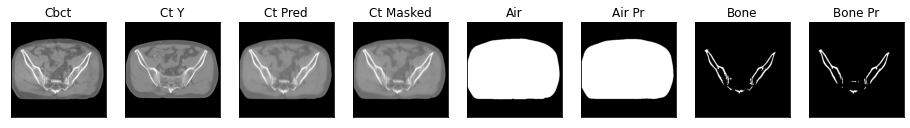

17it [00:42,  2.45s/it]

ssim score = 0.8586191534996033
psnr score = 23.974956512451172
snr score = 15.452346801757812
mae error = 0.025145770981907845
air dice score = 0.9930975173693672
bone dice score = 0.8954746679796425


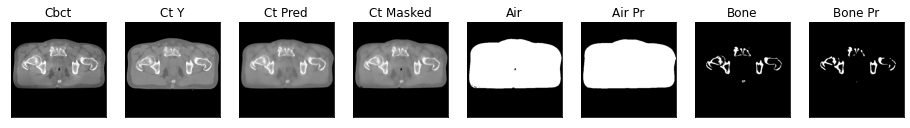

ssim score = 0.8599063158035278
psnr score = 24.19017791748047
snr score = 15.707582473754883
mae error = 0.02423815242946148
air dice score = 0.9925213029552241
bone dice score = 0.8786231884073678


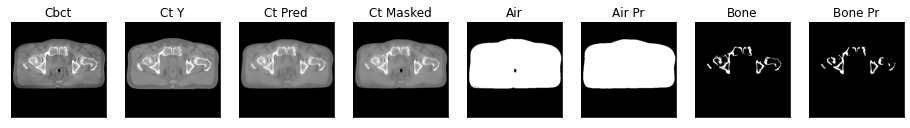

ssim score = 0.858767569065094
psnr score = 24.299198150634766
snr score = 15.824384689331055
mae error = 0.024298205971717834
air dice score = 0.9929440591700814
bone dice score = 0.8531203465567467


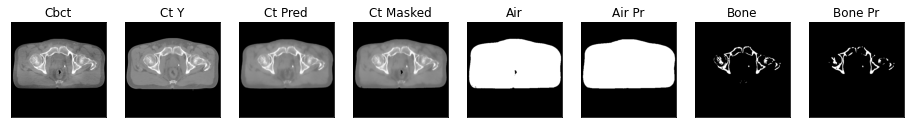

ssim score = 0.8613166809082031
psnr score = 24.374099731445312
snr score = 15.840869903564453
mae error = 0.02359275333583355
air dice score = 0.992812736921916
bone dice score = 0.8573619631920071


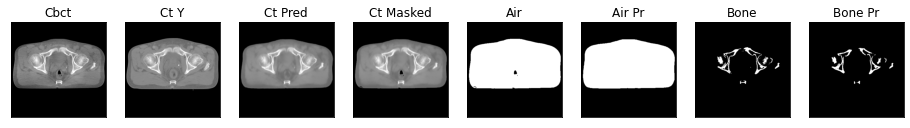

ssim score = 0.8656452298164368
psnr score = 24.504661560058594
snr score = 15.81580924987793
mae error = 0.021930506452918053
air dice score = 0.9929101727243076
bone dice score = 0.8650697392379462


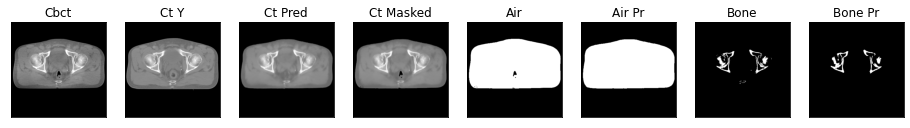

ssim score = 0.8688428997993469
psnr score = 24.540414810180664
snr score = 15.830757141113281
mae error = 0.021736744791269302
air dice score = 0.993153713614814
bone dice score = 0.8842434584771866


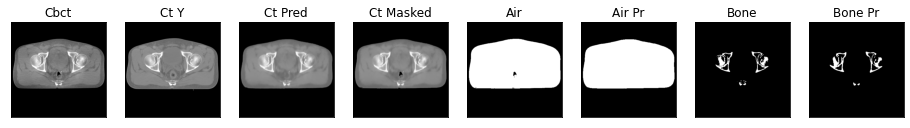

ssim score = 0.869856059551239
psnr score = 24.573183059692383
snr score = 15.847896575927734
mae error = 0.02181169018149376
air dice score = 0.9925633492471596
bone dice score = 0.8963229195480188


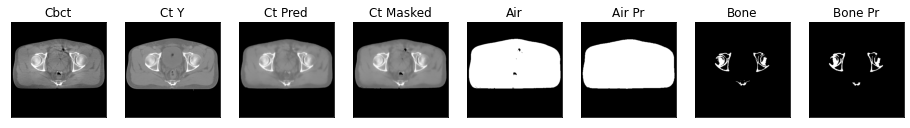

ssim score = 0.8661766052246094
psnr score = 24.05406951904297
snr score = 15.338144302368164
mae error = 0.022918183356523514
air dice score = 0.9913552640678736
bone dice score = 0.8991081382399789


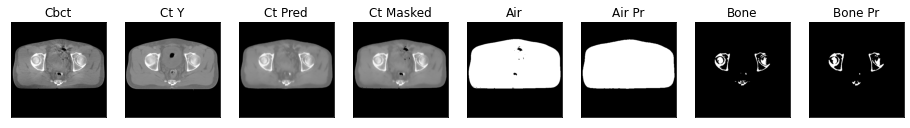

18it [00:44,  2.47s/it]

ssim score = 0.8639033436775208
psnr score = 23.991714477539062
snr score = 15.331573486328125
mae error = 0.023493057116866112
air dice score = 0.9907125997007122
bone dice score = 0.9245411284850504


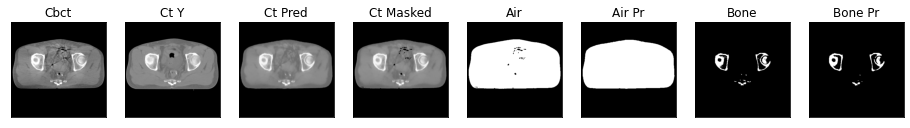

ssim score = 0.8620518445968628
psnr score = 23.527423858642578
snr score = 14.845351219177246
mae error = 0.024484748020768166
air dice score = 0.9891936695819312
bone dice score = 0.9249964951643769


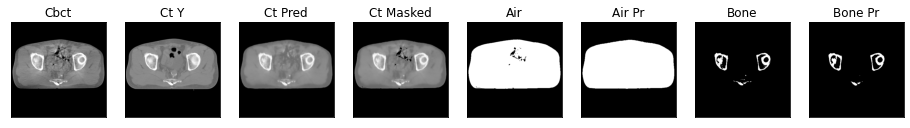

ssim score = 0.8613373041152954
psnr score = 23.11620330810547
snr score = 14.363357543945312
mae error = 0.02454572357237339
air dice score = 0.9884435740209768
bone dice score = 0.8996517885422657


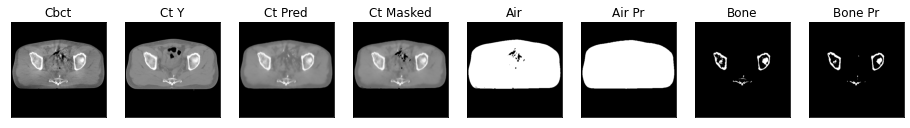

ssim score = 0.8614245653152466
psnr score = 23.340133666992188
snr score = 14.54339599609375
mae error = 0.02400505356490612
air dice score = 0.9905665513084804
bone dice score = 0.9039264828754565


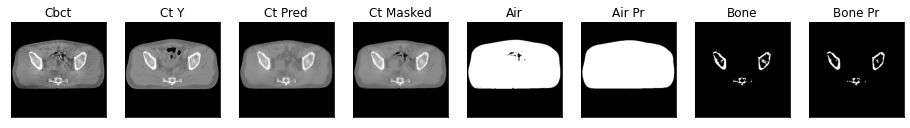

ssim score = 0.8640554547309875
psnr score = 23.69765281677246
snr score = 14.899816513061523
mae error = 0.023431194946169853
air dice score = 0.9901963078219034
bone dice score = 0.9101269944658071


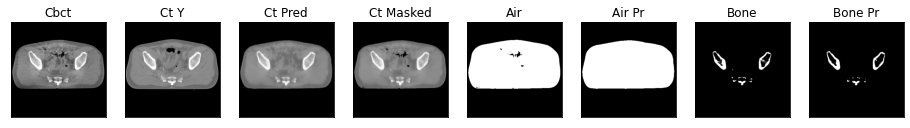

ssim score = 0.8600990772247314
psnr score = 24.042282104492188
snr score = 15.257802963256836
mae error = 0.023203222081065178
air dice score = 0.9878231415197254
bone dice score = 0.9140526976174083


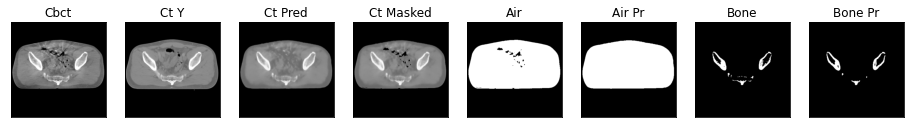

ssim score = 0.8595291376113892
psnr score = 24.34933090209961
snr score = 15.620058059692383
mae error = 0.022709587588906288
air dice score = 0.9869151529448872
bone dice score = 0.9218770310682195


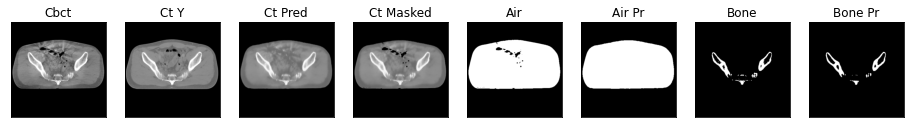

ssim score = 0.859941303730011
psnr score = 23.902759552001953
snr score = 15.192856788635254
mae error = 0.023320946842432022
air dice score = 0.9874580490648782
bone dice score = 0.9190981432371472


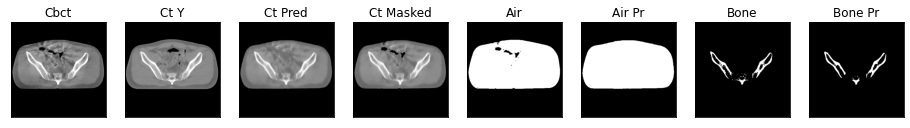

19it [00:46,  2.42s/it]

ssim score = 0.8632078766822815
psnr score = 23.519561767578125
snr score = 14.75491714477539
mae error = 0.02355043962597847
air dice score = 0.9895619816467555
bone dice score = 0.9027034841708442


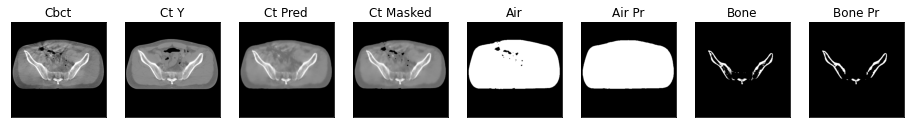

ssim score = 0.8615416288375854
psnr score = 23.400869369506836
snr score = 14.599871635437012
mae error = 0.023825863376259804
air dice score = 0.9914075802484775
bone dice score = 0.8843930635854856


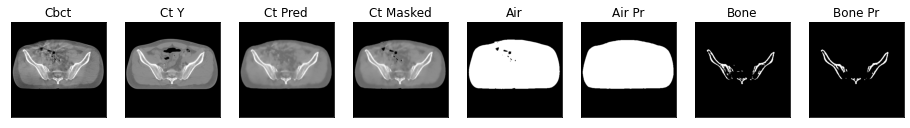

ssim score = 0.8669735789299011
psnr score = 23.532188415527344
snr score = 14.73126220703125
mae error = 0.02319280244410038
air dice score = 0.9920052982638787
bone dice score = 0.8826960466638666


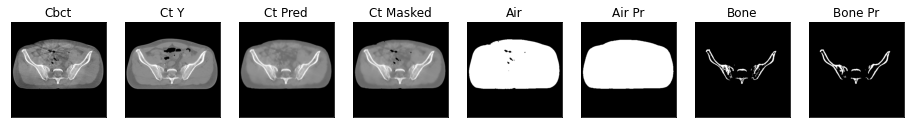

ssim score = 0.8670507073402405
psnr score = 23.92013168334961
snr score = 15.11778450012207
mae error = 0.02293112315237522
air dice score = 0.9906868359729921
bone dice score = 0.8858831254118729


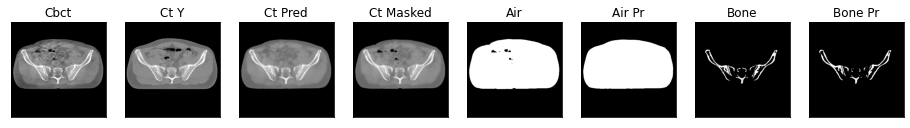

ssim score = 0.8613936901092529
psnr score = 23.68415069580078
snr score = 14.886845588684082
mae error = 0.02388274483382702
air dice score = 0.9883364124358833
bone dice score = 0.8717052178607894


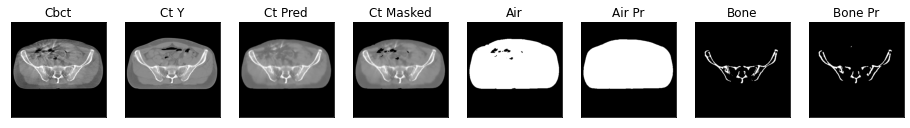

ssim score = 0.8577229976654053
psnr score = 23.405197143554688
snr score = 14.590617179870605
mae error = 0.024516116827726364
air dice score = 0.9858517621566616
bone dice score = 0.869836109984155


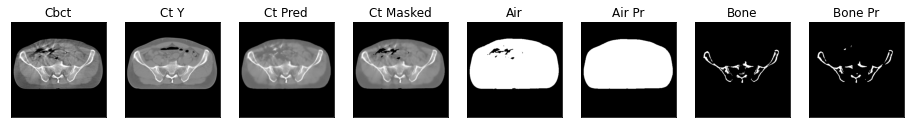

ssim score = 0.8541443347930908
psnr score = 23.019216537475586
snr score = 14.186012268066406
mae error = 0.025697359815239906
air dice score = 0.9853076290076576
bone dice score = 0.8574369531670427


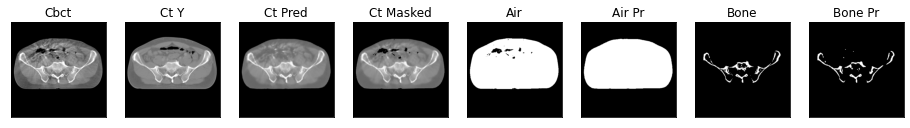

ssim score = 0.8457668423652649
psnr score = 22.59364128112793
snr score = 13.714500427246094
mae error = 0.02700670436024666
air dice score = 0.9846626995250766
bone dice score = 0.8512188992227794


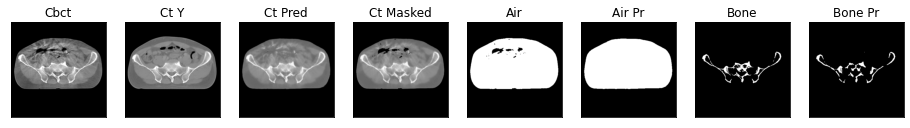

20it [00:49,  2.45s/it]

ssim score = 0.8399155735969543
psnr score = 22.716386795043945
snr score = 13.783446311950684
mae error = 0.027000034227967262
air dice score = 0.9835553839222634
bone dice score = 0.876355219882125


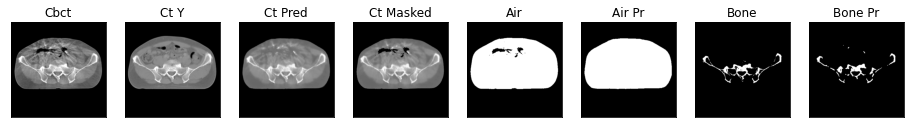

ssim score = 0.8337761759757996
psnr score = 22.401182174682617
snr score = 13.498706817626953
mae error = 0.028437945991754532
air dice score = 0.9841802802350486
bone dice score = 0.8859333812618507


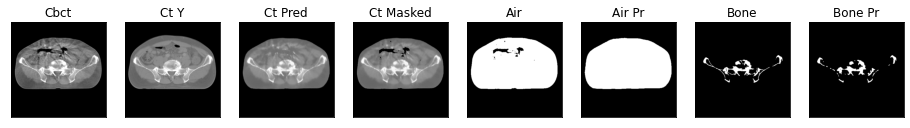

ssim score = 0.8296473622322083
psnr score = 21.902925491333008
snr score = 12.945223808288574
mae error = 0.029032744467258453
air dice score = 0.9852743660695622
bone dice score = 0.8771667290201126


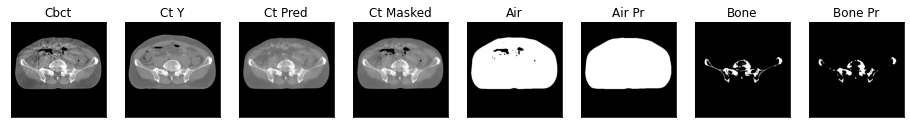

ssim score = 0.8378620743751526
psnr score = 22.562875747680664
snr score = 13.4576416015625
mae error = 0.026871414855122566
air dice score = 0.9881293624188342
bone dice score = 0.8980331262953153


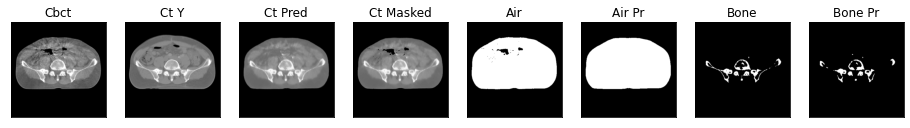

ssim score = 0.8840891718864441
psnr score = 26.663930892944336
snr score = 17.044845581054688
mae error = 0.016752485185861588
air dice score = 0.9955364845502386
bone dice score = 0.9492455418395269


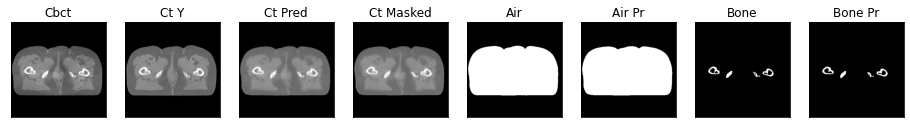

ssim score = 0.8838738799095154
psnr score = 26.81097984313965
snr score = 17.312904357910156
mae error = 0.016784586012363434
air dice score = 0.9956250512398205
bone dice score = 0.9473442170626042


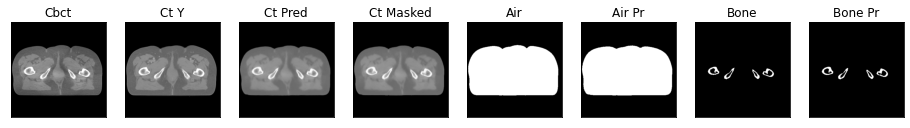

ssim score = 0.8783235549926758
psnr score = 26.65806770324707
snr score = 17.242908477783203
mae error = 0.017366573214530945
air dice score = 0.9953609011412514
bone dice score = 0.9282876855544995


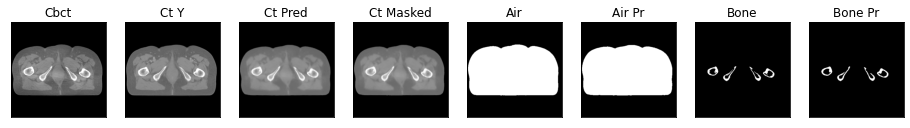

ssim score = 0.8747879266738892
psnr score = 26.560976028442383
snr score = 17.209260940551758
mae error = 0.017742332071065903
air dice score = 0.9951688683350702
bone dice score = 0.9309701492550192


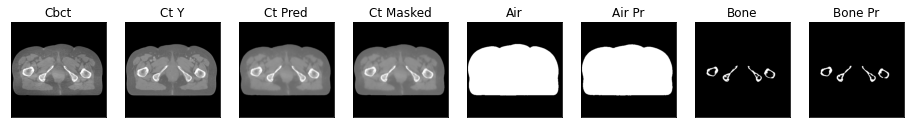

21it [00:51,  2.47s/it]

ssim score = 0.8742836713790894
psnr score = 26.391769409179688
snr score = 17.068517684936523
mae error = 0.0181652270257473
air dice score = 0.9952797588412652
bone dice score = 0.9252067601595612


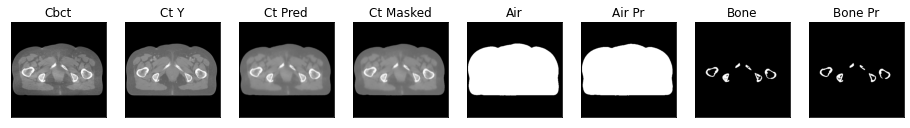

ssim score = 0.8757954835891724
psnr score = 26.309011459350586
snr score = 17.008716583251953
mae error = 0.018129920586943626
air dice score = 0.995204364468304
bone dice score = 0.9268745360072963


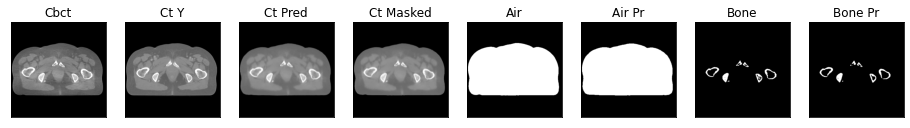

ssim score = 0.8726360201835632
psnr score = 26.15103530883789
snr score = 16.882062911987305
mae error = 0.01847713254392147
air dice score = 0.9952594153278939
bone dice score = 0.9114766216981801


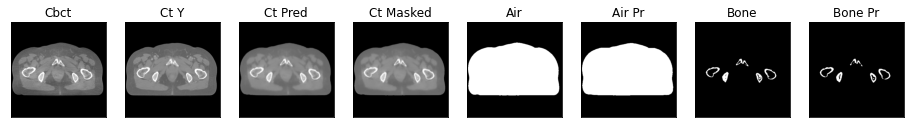

ssim score = 0.8724455237388611
psnr score = 26.07259750366211
snr score = 16.85198974609375
mae error = 0.018877027556300163
air dice score = 0.994393643693036
bone dice score = 0.9166517297021571


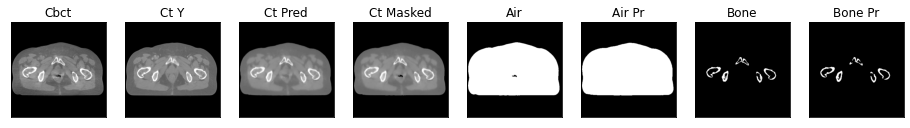

ssim score = 0.873593807220459
psnr score = 26.054906845092773
snr score = 16.877044677734375
mae error = 0.018798498436808586
air dice score = 0.9936656608681086
bone dice score = 0.91593141335249


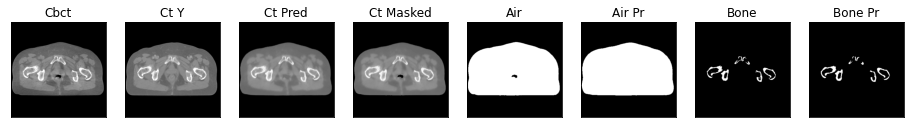

ssim score = 0.8728986382484436
psnr score = 26.2089900970459
snr score = 17.118831634521484
mae error = 0.018782878294587135
air dice score = 0.992640616786408
bone dice score = 0.9078095786004917


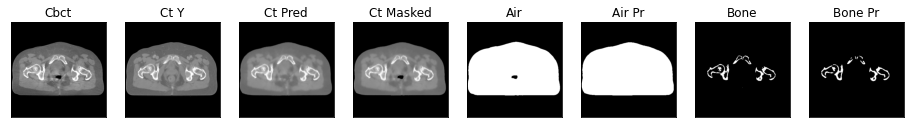

ssim score = 0.8730430603027344
psnr score = 26.489543914794922
snr score = 17.51265525817871
mae error = 0.018621524795889854
air dice score = 0.9943969845589667
bone dice score = 0.9119481765845495


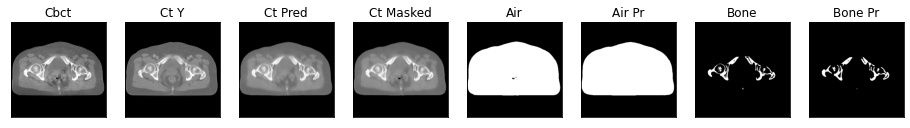

ssim score = 0.8772372603416443
psnr score = 26.80303955078125
snr score = 17.697599411010742
mae error = 0.017916668206453323
air dice score = 0.9918308855087388
bone dice score = 0.8874785591786024


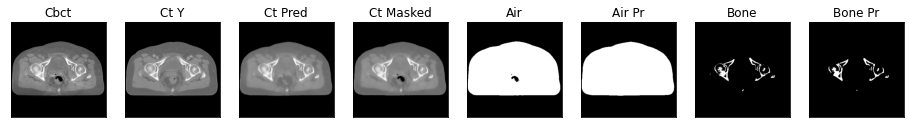

22it [00:54,  2.42s/it]

ssim score = 0.8781444430351257
psnr score = 27.15854263305664
snr score = 17.943679809570312
mae error = 0.017478369176387787
air dice score = 0.9915161904208554
bone dice score = 0.8750486570674377


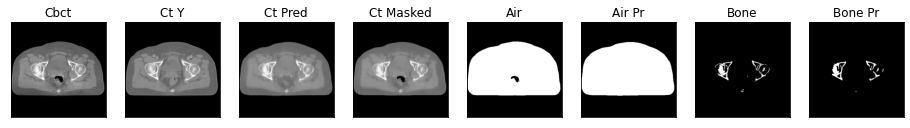

ssim score = 0.8800423741340637
psnr score = 26.881832122802734
snr score = 17.63984489440918
mae error = 0.01819770224392414
air dice score = 0.9920203907257013
bone dice score = 0.8913726859956099


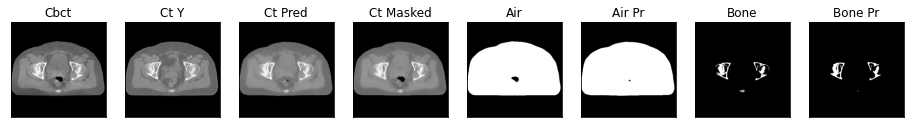

ssim score = 0.8817551732063293
psnr score = 26.750123977661133
snr score = 17.500131607055664
mae error = 0.018871847540140152
air dice score = 0.9938454459175794
bone dice score = 0.8983419862686595


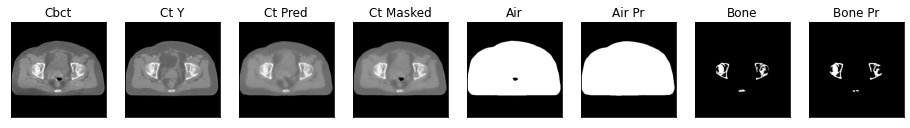

ssim score = 0.880689263343811
psnr score = 26.963560104370117
snr score = 17.7477970123291
mae error = 0.018015671521425247
air dice score = 0.9955940227000545
bone dice score = 0.9296616837147181


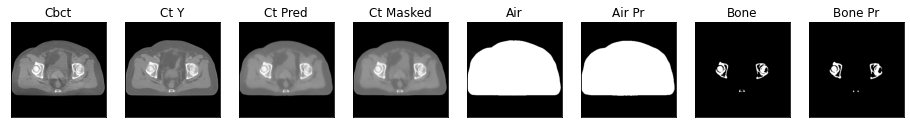

ssim score = 0.8753761649131775
psnr score = 26.465091705322266
snr score = 17.30082130432129
mae error = 0.018820935860276222
air dice score = 0.9960023490621468
bone dice score = 0.9458483754521135


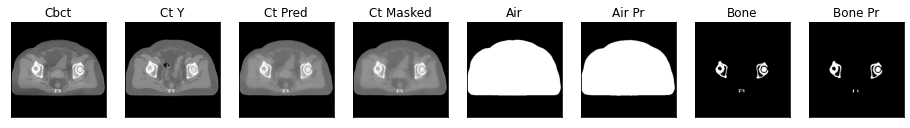

ssim score = 0.8643805384635925
psnr score = 25.447002410888672
snr score = 16.320287704467773
mae error = 0.020373711362481117
air dice score = 0.9960490396289072
bone dice score = 0.9350199272234445


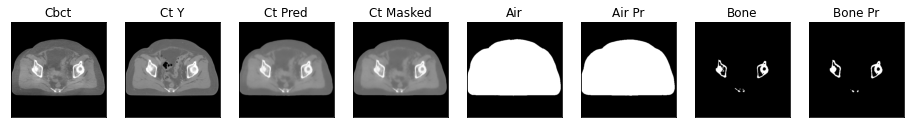

ssim score = 0.851809561252594
psnr score = 24.098526000976562
snr score = 14.899373054504395
mae error = 0.022605571895837784
air dice score = 0.9937904647743075
bone dice score = 0.9219889502779671


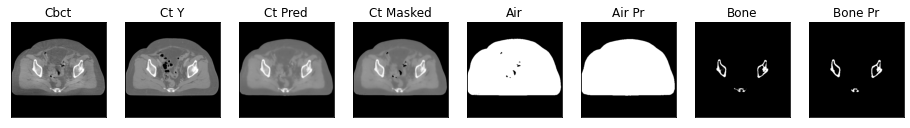

ssim score = 0.8484482765197754
psnr score = 24.093738555908203
snr score = 14.876595497131348
mae error = 0.023153675720095634
air dice score = 0.991698374264966
bone dice score = 0.9293931874592963


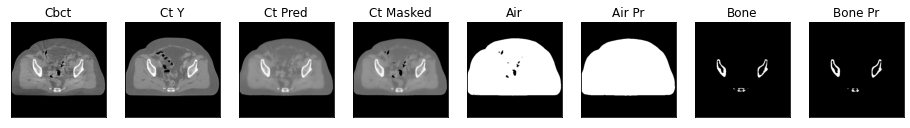

23it [00:56,  2.45s/it]

ssim score = 0.8480722308158875
psnr score = 24.514493942260742
snr score = 15.362266540527344
mae error = 0.022804733365774155
air dice score = 0.9922361631707755
bone dice score = 0.933275750379329


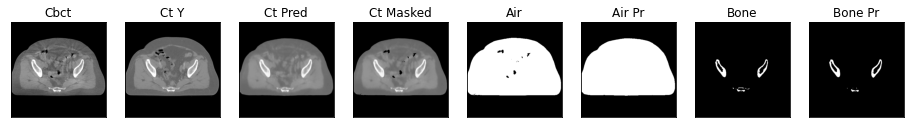

ssim score = 0.8474715352058411
psnr score = 24.34853744506836
snr score = 15.25140380859375
mae error = 0.023283028975129128
air dice score = 0.9922751329940876
bone dice score = 0.9262218918430362


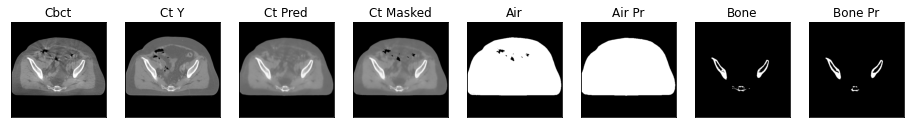

ssim score = 0.8440757393836975
psnr score = 23.98221206665039
snr score = 14.949508666992188
mae error = 0.0243217796087265
air dice score = 0.9933240012921333
bone dice score = 0.9232203916704504


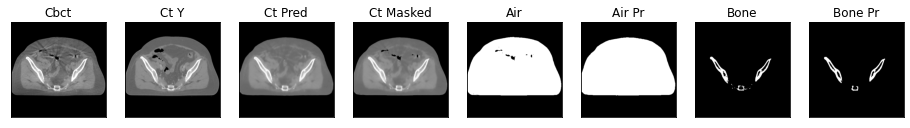

ssim score = 0.8451451659202576
psnr score = 24.050556182861328
snr score = 15.090709686279297
mae error = 0.024584226310253143
air dice score = 0.9925392058725442
bone dice score = 0.9070975187549467


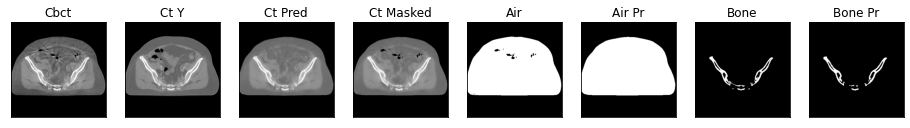

ssim score = 0.8431251049041748
psnr score = 24.169462203979492
snr score = 15.20532512664795
mae error = 0.02461007982492447
air dice score = 0.9918446242039957
bone dice score = 0.9020521030431953


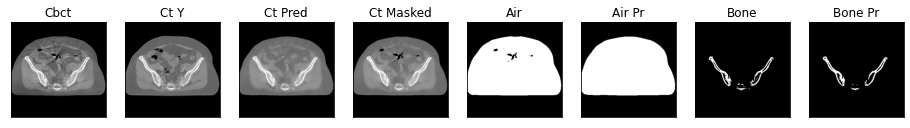

ssim score = 0.8410829901695251
psnr score = 23.908912658691406
snr score = 14.922598838806152
mae error = 0.024954773485660553
air dice score = 0.9932880627146684
bone dice score = 0.8967254408074905


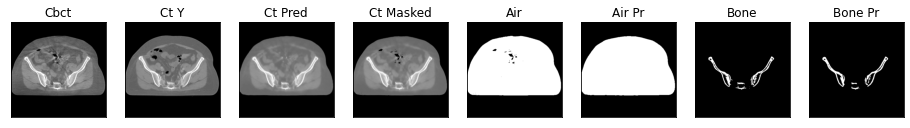

ssim score = 0.8460275530815125
psnr score = 24.394197463989258
snr score = 15.419520378112793
mae error = 0.024040624499320984
air dice score = 0.9947252861467341
bone dice score = 0.8909853249492216


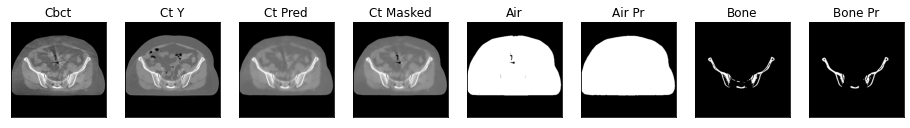

24it [00:59,  2.46s/it]


In [34]:
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [35]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [36]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [37]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test, score_acc_test 
# unmasked
eval_epoch(model, discriminator, testloader, device)

24it [00:05,  4.27it/s]


(0.8553127894798914,
 24.349731127421062,
 15.364301323890686,
 0.0240680492327859,
 0.9905924337841299,
 0.9127406100083824,
 0.5)

In [ ]:
# import torchvision.models as models
# models.vgg16(pretrained=True)